In [12]:
###### STAGE 1 : Comparison of different PRNGs on SMA.

In [13]:
"""
3.1 ANOVA : test for equality of variances
    • We compare amplitudes of the first infection peak of simulations arising
    from different platforms and languages. In this context, we select the
    maximum value of the first infection peak from each simulation in order
    to apply an ANOVA test.
    • The ANOVA is used to compare the mean of more than two groups, the
    null hypothesis being ”the averages of the different samples are equal”
    (Rupert G. Miller, Jr (1997)) against the alternative being ”at least one
    of the samples differs significatively from the overall mean”. We test if
    there is equality of mean between the maximum value of the first infection
    peak of the different samples.
    • Assumptions to apply the test : normality (the distributions of the residuals are normal), equality of variances (homoscedasticity : the variance of
    data in groups should be the same).
3.2 Kruskal Wallis test : one-way ANOVA on ranks
    • Alternative to ANOVA test when the normality hypothesis is not checked.
    The null hypothesis is ”population means are equal” (Kruskal & Wallis,
    1952).
    • We apply it on the step associated to the maximum value of the first
    infection peak. We test if the averages of the different samples are similar.
3.3 Clustering
    • Comparing amplitudes and time of apparition of the epidemic maximum
    is not enough to compare the epidemic evolution in time. We cluster
    the entire time series to evaluate their similarities in terms of shape and
    simultaneity.
    • ”The goal of clustering is to identify structure in an unlabeled data set by
    objectively organizing data into homogeneous groups where the withingroup-object similarity is minimized and the between-group-object dissimilarity is maximized” (Warren Liao (2005)).
    • We apply an hybrid hierarchical k-means clustering (Hasan and all (2015)),
    using two distinct similarity distances : Euclidean and Dynamic Time
    Warping (DTW).
    • As k-means clustering requires a specified number of clusters and chooses
    initial centroids randomly, we first apply a hierarchical clustering to choose
    an optimal number of classes. We compute the center (i.e. mean) of each
    class and then apply the k-means by using the set of cluster centers as
    the initial cluster centers. K-means helps improve the performance of the
    hierarchical clustering as it cannot adjust the clusters after merging them
    in an agglomerative method (Hasan and all (2015)).
    3.3.1 Euclidean distance matrix
        • We use the euclidean distance to compare the amplitude of the time series
        step by step. Comparing step by step makes it very sensitive to shifting,
        time warping, uniform amplitude scaling, uniform time scaling, uniform
        bi-scaling and non-uniform amplitude scaling (Perng (2000)).
        • DTW (Keogh, Ratanamahatana (2002)) gives more robustness to the similarity computation.
    3.3.2 Dynamic Time Warping (DTW) distance matrix
        • The main feature of the DTW distance measure is that it allows to recognize similar shapes, even if they present signal transformations, such as
        shifting and/or scaling (Keogh, Ratanamahatana (2002)). It takes into
        account out-of-phase similarities unlike euclidean distance.
        • ”DTW gauges morphological similarity by minimising the Euclidean distance between two time series of duration t, through the deformation
        (remapping) of the time indices” (Rollier and all (2023)). It replaces the
        one to-one point comparison, used in Euclidean distance, with a many-toone (Toni, Giorgino (2009)).
        
"""

'\n3.1 ANOVA : test for equality of variances\n    • We compare amplitudes of the first infection peak of simulations arising\n    from different platforms and languages. In this context, we select the\n    maximum value of the first infection peak from each simulation in order\n    to apply an ANOVA test.\n    • The ANOVA is used to compare the mean of more than two groups, the\n    null hypothesis being ”the averages of the different samples are equal”\n    (Rupert G. Miller, Jr (1997)) against the alternative being ”at least one\n    of the samples differs significatively from the overall mean”. We test if\n    there is equality of mean between the maximum value of the first infection\n    peak of the different samples.\n    • Assumptions to apply the test : normality (the distributions of the residuals are normal), equality of variances (homoscedasticity : the variance of\n    data in groups should be the same).\n3.2 Kruskal Wallis test : one-way ANOVA on ranks\n    • Alternative t

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd
import os
from statistics import mean, variance
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Define constants
NB_REPLICATION = 30
NOM_EXPERIENCE = "configVaccin"
listDptConfig = ["configDpt75"]
base_dirs = [
    "SMA-Covid-V2-ZZ3-MRG", "SMA-Covid-SparseMatrix-MRG",
    "SMA-Covid-V2-ZZ3-MT", "SMA-Covid-SparseMatrix-MT",
    "SMA-Covid-SparseMatrix-PCG","SMA-Covid-V2-ZZ3-PCG", 
    "SMA-Covid-SparseMatrix-Philox","SMA-Covid-V2-ZZ3-Philox"
]

# Collecting all `listNbNouvCas` data
all_nb_nouv_cas = []
nbRandomGenere = 0
nbHumainSimuDepart = 0

def extract_experiment_results(folder, dpt_config, prng, repl_num):
    listNumIteration = []
    listNbNouvCas = []
    
    file_path = os.path.join(folder, f"log-{NOM_EXPERIENCE}-{dpt_config}-{prng}-NumRepli{repl_num}.txt")
    with open(file_path, 'r') as f:
        fileLines = f.readlines()
    
    i = 0
    for line in fileLines:
        if "CompteurRand:" in line:
            listSplit = line.split(":")
            nbRandomGenere = int(listSplit[1])
        elif "NbHumainSimuDepart:" in line:
            listSplit = line.split(":")
            nbHumainSimuDepart = int(listSplit[1])
        elif "##" not in line:
            if i == 0:
                listNumIteration.append(int(line))
                i += 1
            elif i == 1:
                listNbNouvCas.append(int(line))
                i += 1   
        else:
            i = 0
        
    return listNumIteration, listNbNouvCas

def process_experiments():
    global all_nb_nouv_cas  # Make sure we can access the list
    for folder in base_dirs:
        for dpt_config in listDptConfig:
            prng = folder.split("-")[-1]

            for repl_num in range(NB_REPLICATION):
                listNumIteration, listNbNouvCas = extract_experiment_results(folder, dpt_config, prng, repl_num)
                all_nb_nouv_cas.append(listNbNouvCas)

process_experiments()




ANOVA test result for peaks: F-value=0.6063446783926348, p-value=0.750436264432842
ANOVA test result for peak dates: F-value=0.3151844497857665, p-value=0.9467037234869932


/tmp/ipykernel_191682/2958314128.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([infection_peaks[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))], labels=base_dirs)


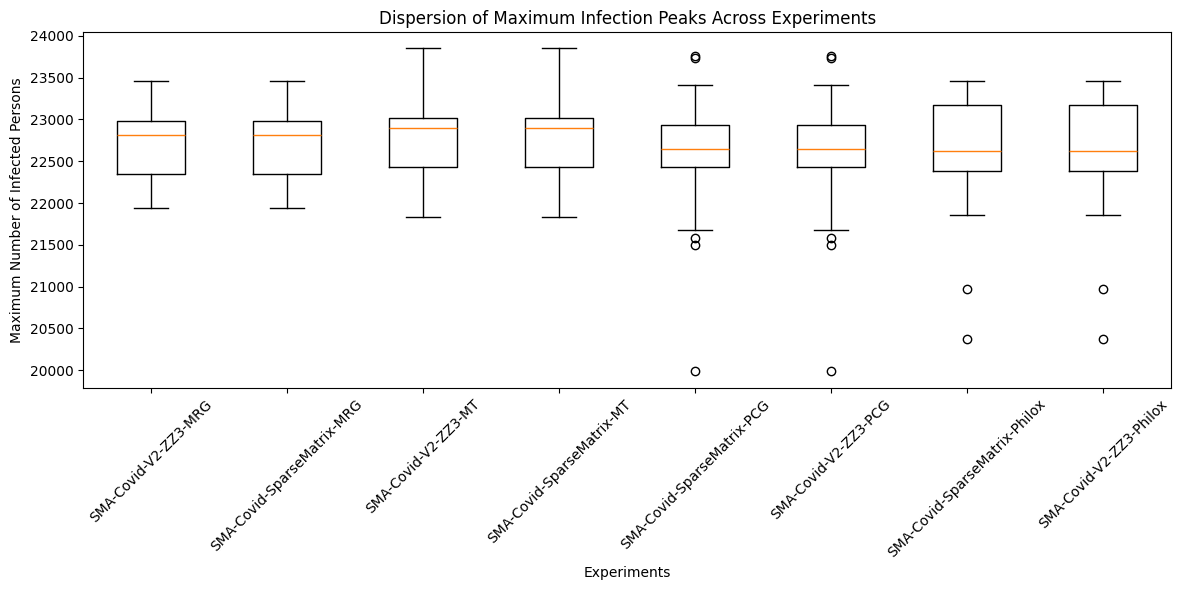

/tmp/ipykernel_191682/2958314128.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([peak_dates[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))], labels=base_dirs)


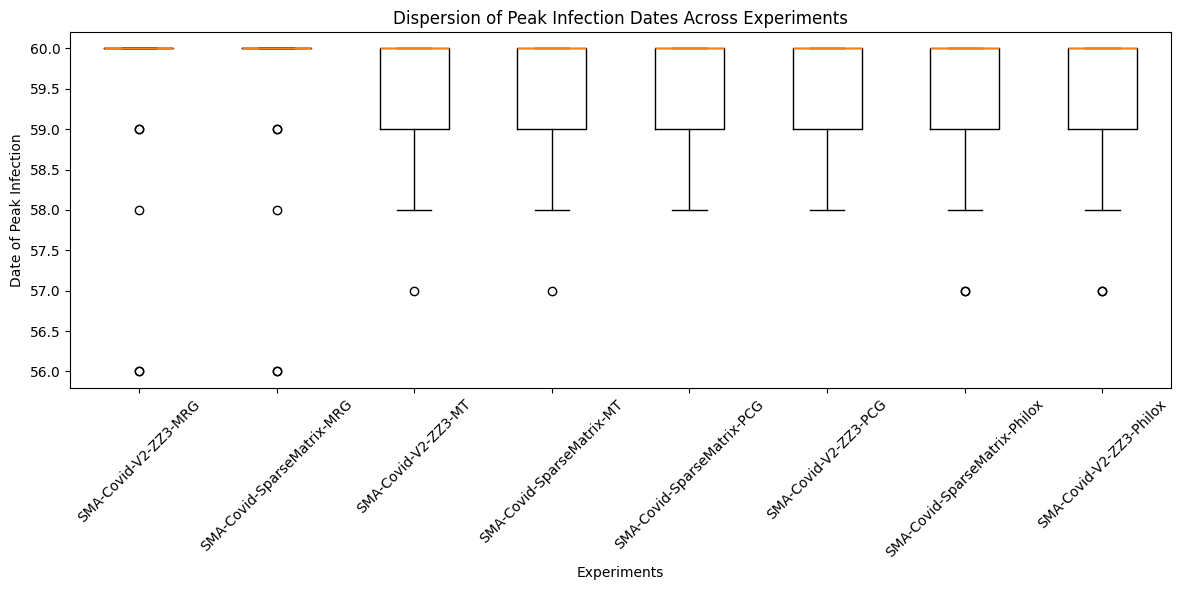

In [15]:
# Extract first infection peaks and their corresponding dates from `all_nb_nouv_cas`
infection_peaks = [max(cas_list[:300]) for cas_list in all_nb_nouv_cas]  # Assuming first peak is within first 300 days
peak_dates = [cas_list[:300].index(max(cas_list[:300])) for cas_list in all_nb_nouv_cas]

# Compute means of the 30 replications for each experiment
mean_peaks_per_experiment = [np.mean(infection_peaks[i*NB_REPLICATION:(i+1)*NB_REPLICATION]) for i in range(len(base_dirs))]
mean_dates_per_experiment = [np.mean(peak_dates[i*NB_REPLICATION:(i+1)*NB_REPLICATION]) for i in range(len(base_dirs))]

# Perform ANOVA on the mean values of infection peaks
f_val_peaks, p_val_peaks = st.f_oneway(*[infection_peaks[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))])
print(f"ANOVA test result for peaks: F-value={f_val_peaks}, p-value={p_val_peaks}")

# Perform ANOVA on the mean values of peak dates
f_val_dates, p_val_dates = st.f_oneway(*[peak_dates[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))])
print(f"ANOVA test result for peak dates: F-value={f_val_dates}, p-value={p_val_dates}")

# Plot boxplots for infection peaks and peak dates
plt.figure(figsize=(12, 6))
plt.boxplot([infection_peaks[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))], labels=base_dirs)
plt.xlabel("Experiments")
plt.ylabel("Maximum Number of Infected Persons")
plt.title("Dispersion of Maximum Infection Peaks Across Experiments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.boxplot([peak_dates[i*NB_REPLICATION:(i+1)*NB_REPLICATION] for i in range(len(base_dirs))], labels=base_dirs)
plt.xlabel("Experiments")
plt.ylabel("Date of Peak Infection")
plt.title("Dispersion of Peak Infection Dates Across Experiments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [16]:
"""
Interpretation of ANOVA Test Results

The ANOVA (Analysis of Variance) tests are used to determine whether there are any statistically significant differences between the means of multiple groups. Here, two ANOVA tests were conducted:

    ANOVA Test on Infection Peaks:
        F-value: 0.6063446783926348
        p-value: 0.750436264432842

    ANOVA Test on Peak Dates:
        F-value: 0.3151844497857665
        p-value: 0.9467037234869932

ANOVA Test on Infection Peaks

Hypotheses:

    Null Hypothesis (H0): There is no significant difference in the means of infection peaks across the different experiments.
    Alternative Hypothesis (H1): There is a significant difference in the means of infection peaks across the different experiments.

Interpretation:

    F-value: The F-value is the ratio of the variance between the group means to the variance within the groups. An F-value close to 1 suggests that the variances between the groups are similar to the variances within the groups, indicating no significant difference.
    p-value: The p-value indicates the probability of obtaining an F-value as extreme as, or more extreme than, the observed one, assuming the null hypothesis is true. A common threshold for significance is 0.05.

In this case, the p-value is 0.750436264432842, which is much greater than 0.05. Therefore, we fail to reject the null hypothesis. This means that there is no significant difference in the means of infection peaks across the different experiments.
ANOVA Test on Peak Dates

Hypotheses:

    Null Hypothesis (H0): There is no significant difference in the means of peak dates across the different experiments.
    Alternative Hypothesis (H1): There is a significant difference in the means of peak dates across the different experiments.

Interpretation:

    F-value: The F-value for the peak dates is 0.3151844497857665, which again suggests that the variances between the groups are similar to the variances within the groups.
    p-value: The p-value for the peak dates is 0.9467037234869932, which is also much greater than 0.05.

Similarly, in this case, the p-value is 0.9467037234869932, indicating that we fail to reject the null hypothesis. This means that there is no significant difference in the means of peak dates across the different experiments.
"""

'\nInterpretation of ANOVA Test Results\n\nThe ANOVA (Analysis of Variance) tests are used to determine whether there are any statistically significant differences between the means of multiple groups. Here, two ANOVA tests were conducted:\n\n    ANOVA Test on Infection Peaks:\n        F-value: 0.6063446783926348\n        p-value: 0.750436264432842\n\n    ANOVA Test on Peak Dates:\n        F-value: 0.3151844497857665\n        p-value: 0.9467037234869932\n\nANOVA Test on Infection Peaks\n\nHypotheses:\n\n    Null Hypothesis (H0): There is no significant difference in the means of infection peaks across the different experiments.\n    Alternative Hypothesis (H1): There is a significant difference in the means of infection peaks across the different experiments.\n\nInterpretation:\n\n    F-value: The F-value is the ratio of the variance between the group means to the variance within the groups. An F-value close to 1 suggests that the variances between the groups are similar to the varianc

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


print(all_nb_nouv_cas)
print(len(all_nb_nouv_cas))





[[0, 43, 97, 78, 108, 107, 118, 111, 129, 139, 180, 167, 202, 231, 290, 295, 355, 386, 411, 466, 524, 596, 731, 757, 905, 967, 1108, 1303, 1463, 1640, 1845, 2042, 2325, 2580, 2872, 3237, 3596, 4026, 4517, 5010, 5554, 6279, 6902, 7649, 8369, 9255, 10125, 11083, 12063, 13140, 14340, 15286, 16553, 17522, 18461, 19579, 20494, 21284, 22128, 22627, 23177, 20174, 19157, 17305, 16048, 14398, 13235, 11975, 10937, 9752, 8936, 7884, 7092, 6249, 5395, 4802, 4267, 3748, 3329, 2859, 2518, 2245, 2028, 1793, 1606, 1420, 1259, 1080, 991, 814, 794, 615, 593, 466, 439, 364, 304, 318, 242, 243, 191, 132, 110, 50, 63, 45, 41, 25, 18, 13, 11, 12, 5, 6, 3, 2, 3, 1, 3, 3, 1, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

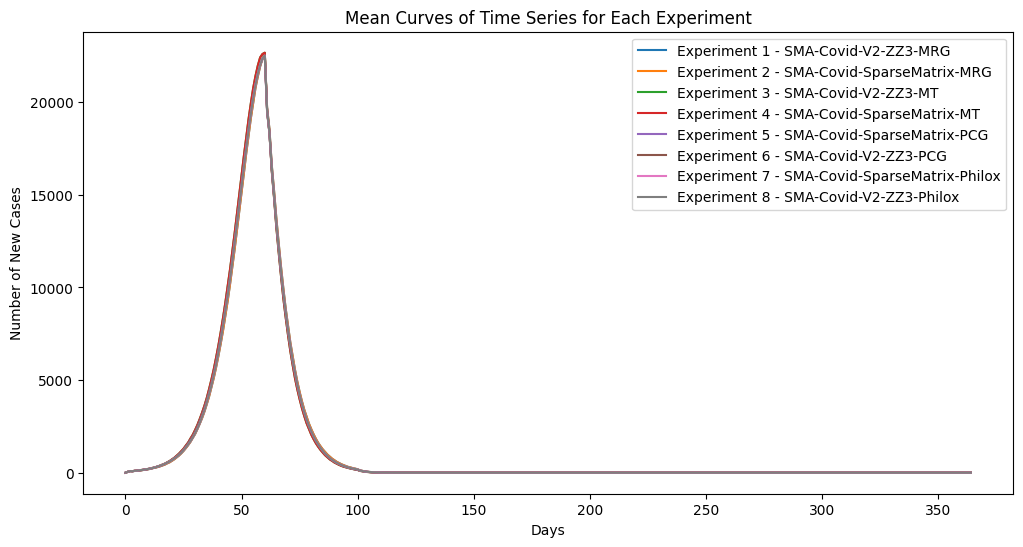

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
all_nb_nouv_cas_np = [np.array(ts) for ts in all_nb_nouv_cas]

experiment_labels = np.repeat(range(1, 9), NB_REPLICATION)

# Calculate the mean time series for each experiment
mean_curves = []
for i in range(1, 9):
    experiment_series = [all_nb_nouv_cas_np[j] for j in range(len(all_nb_nouv_cas_np)) if experiment_labels[j] == i]
    mean_curve = np.mean(experiment_series, axis=0)
    mean_curves.append(mean_curve)

# Plot all mean curves in the same graph
plt.figure(figsize=(12, 6))
for i, mean_curve in enumerate(mean_curves):
    plt.plot(mean_curve, label=f'Experiment {i+1} - {base_dirs[i]}')

plt.title("Mean Curves of Time Series for Each Experiment")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.legend()
plt.show()


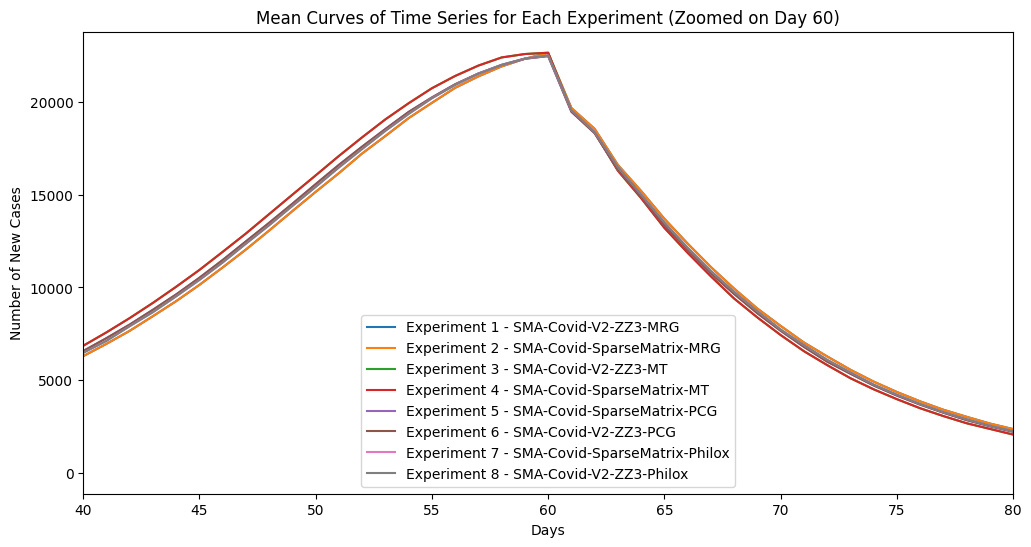

In [19]:
# Plot all mean curves in the same graph and zoom in on day 60
plt.figure(figsize=(12, 6))
for i, mean_curve in enumerate(mean_curves):
    plt.plot(mean_curve, label=f'Experiment {i+1} - {base_dirs[i]}')

plt.title("Mean Curves of Time Series for Each Experiment (Zoomed on Day 60)")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.xlim(40, 80)  # Adjust the x-axis to zoom in on day 60
plt.legend()
plt.show()


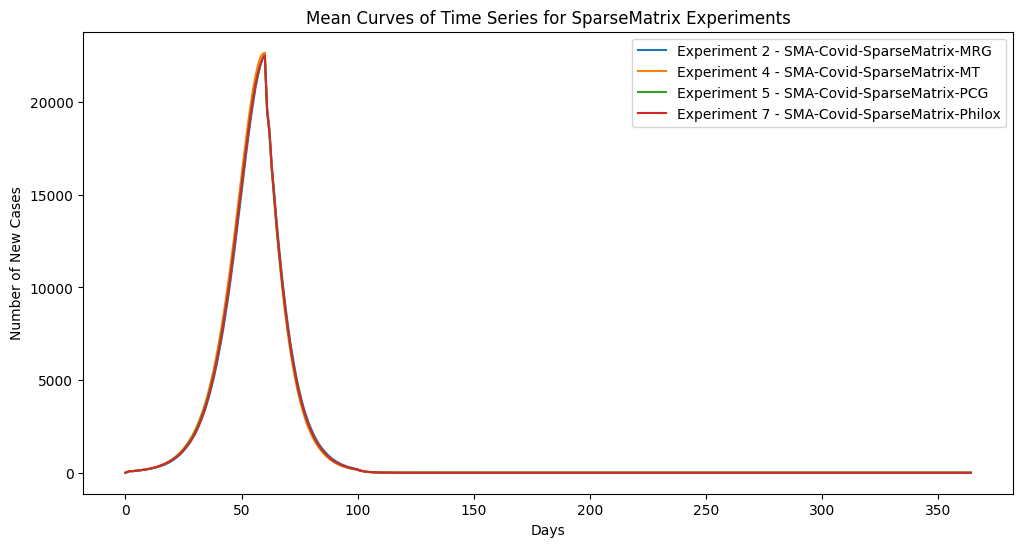

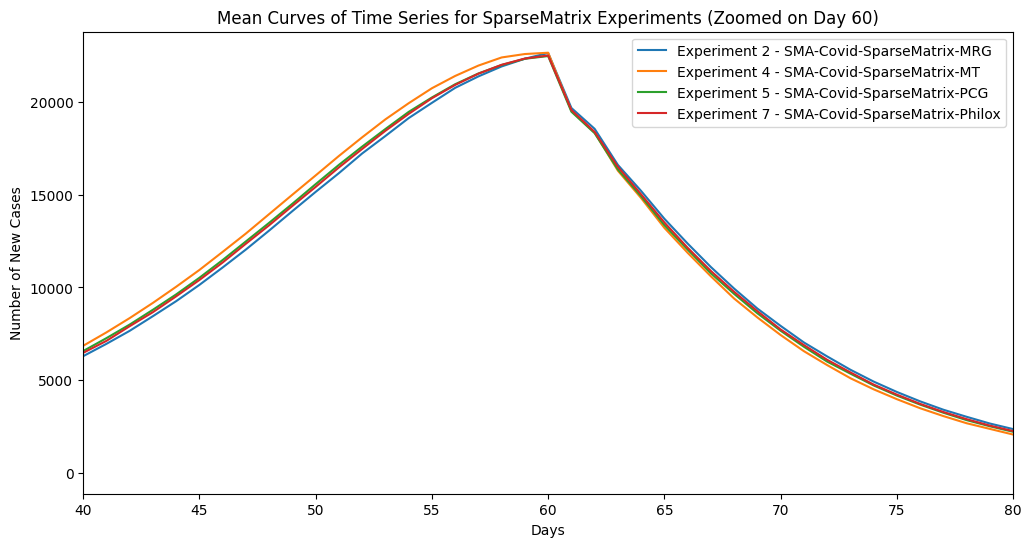

In [20]:
# Filter for experiments with "SparseMatrix" in their name
sparse_matrix_indices = [i for i, name in enumerate(base_dirs) if "SparseMatrix" in name]
sparse_matrix_curves = [mean_curves[i] for i in sparse_matrix_indices]
sparse_matrix_names = [base_dirs[i] for i in sparse_matrix_indices]

# Plot the mean curves for experiments with "SparseMatrix" in their name
plt.figure(figsize=(12, 6))
for i, mean_curve in enumerate(sparse_matrix_curves):
    plt.plot(mean_curve, label=f'Experiment {sparse_matrix_indices[i] + 1} - {sparse_matrix_names[i]}')

plt.title("Mean Curves of Time Series for SparseMatrix Experiments")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.legend()
plt.show()

# Plot the mean curves for experiments with "SparseMatrix" in their name, zoomed in on day 60
plt.figure(figsize=(12, 6))
for i, mean_curve in enumerate(sparse_matrix_curves):
    plt.plot(mean_curve, label=f'Experiment {sparse_matrix_indices[i] + 1} - {sparse_matrix_names[i]}')

plt.title("Mean Curves of Time Series for SparseMatrix Experiments (Zoomed on Day 60)")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.xlim(40, 80)  # Adjust the x-axis to zoom in on day 60
plt.legend()
plt.show()


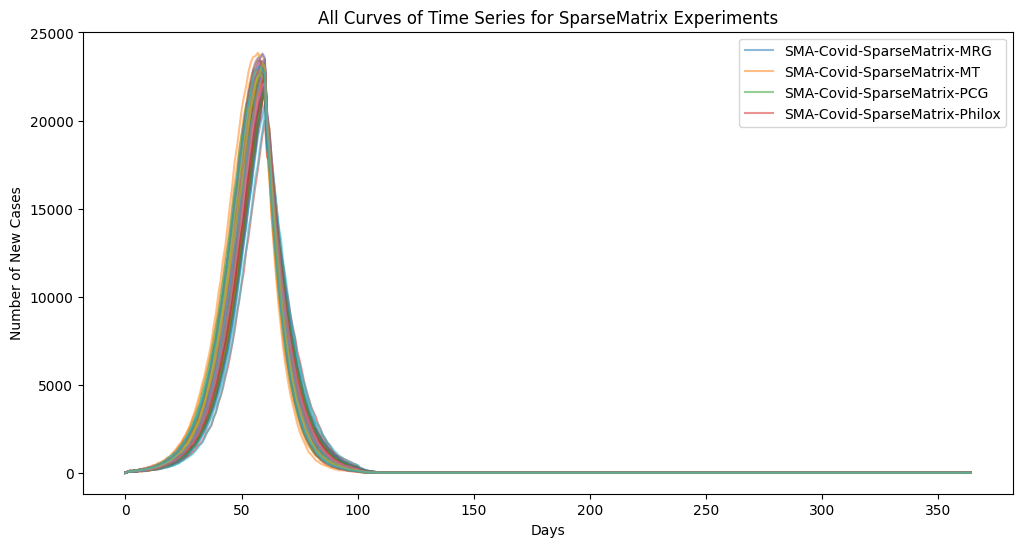

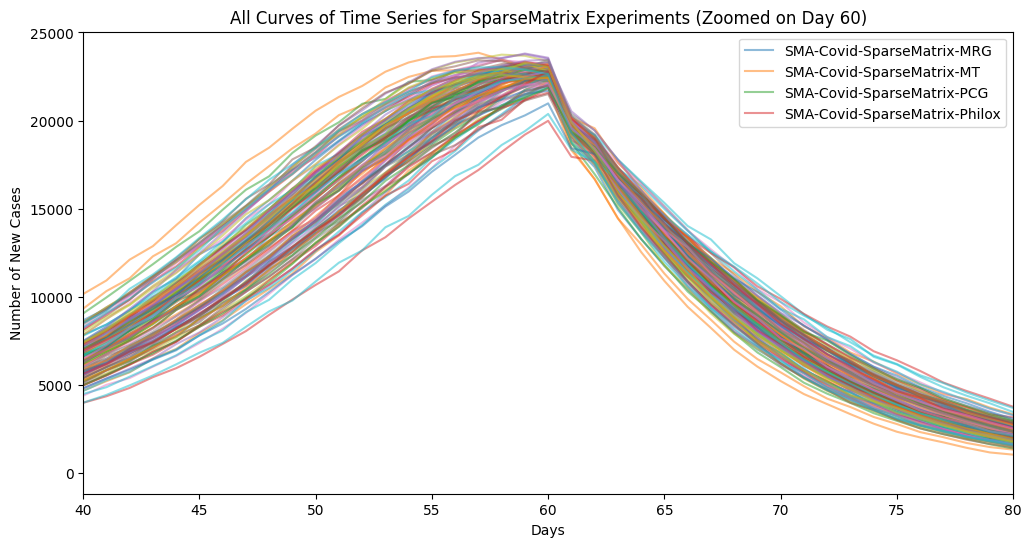

In [21]:
# Filter for experiments with "SparseMatrix" in their name
sparse_matrix_indices = [i for i, name in enumerate(base_dirs) if "SparseMatrix" in name]
sparse_matrix_names = [base_dirs[i] for i in sparse_matrix_indices]

# Plot all curves for experiments with "SparseMatrix" in their name
plt.figure(figsize=(12, 6))
for idx in sparse_matrix_indices:
    for j in range(NB_REPLICATION):
        plt.plot(all_nb_nouv_cas_np[idx * NB_REPLICATION + j], alpha=0.5)

plt.title("All Curves of Time Series for SparseMatrix Experiments")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.legend(sparse_matrix_names)
plt.show()

# Plot the curves for experiments with "SparseMatrix" in their name, zoomed in on day 60
plt.figure(figsize=(12, 6))
for idx in sparse_matrix_indices:
    for j in range(NB_REPLICATION):
        plt.plot(all_nb_nouv_cas_np[idx * NB_REPLICATION + j], alpha=0.5)

plt.title("All Curves of Time Series for SparseMatrix Experiments (Zoomed on Day 60)")
plt.xlabel("Days")
plt.ylabel("Number of New Cases")
plt.xlim(40, 80)  # Adjust the x-axis to zoom in on day 60
plt.legend(sparse_matrix_names)
plt.show()

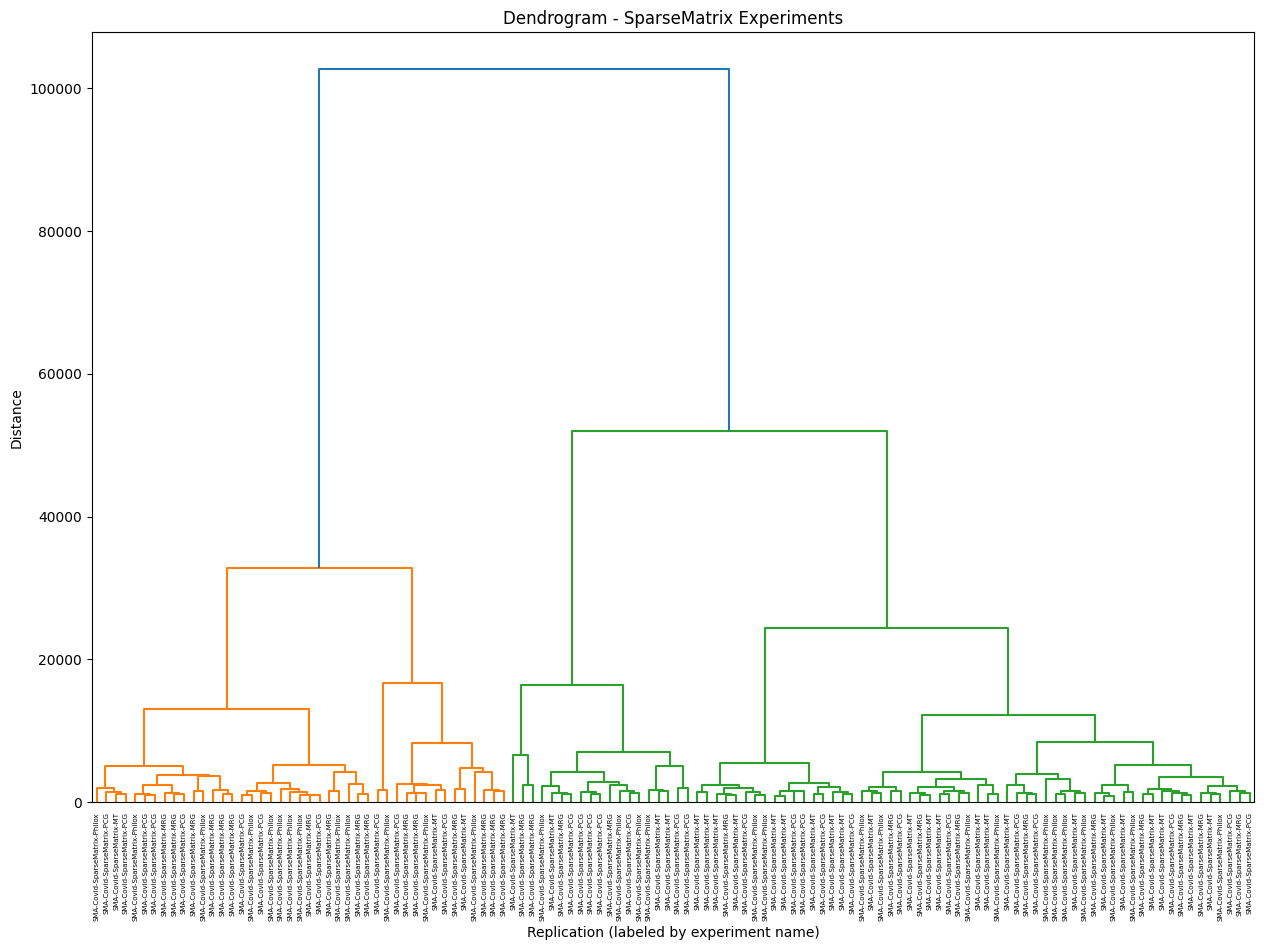

In [22]:
# Filter for experiments with "SparseMatrix" in their name
sparse_matrix_indices = [i for i, name in enumerate(base_dirs) if "SparseMatrix" in name]
sparse_matrix_names = [base_dirs[i] for i in sparse_matrix_indices]

# Extract the corresponding time series data for SparseMatrix experiments
sparse_matrix_data = []
sparse_matrix_experiment_labels = []
for idx in sparse_matrix_indices:
    for j in range(NB_REPLICATION):
        sparse_matrix_data.append(all_nb_nouv_cas_np[idx * NB_REPLICATION + j])
        sparse_matrix_experiment_labels.append(sparse_matrix_names[sparse_matrix_indices.index(idx)])

# Perform hierarchical clustering with Euclidean distance
sparse_matrix_linkage = linkage(sparse_matrix_data, method='ward', metric='euclidean')

# Plot the dendrogram and label each replication with the experiment name
plt.figure(figsize=(15, 10))
dendrogram(sparse_matrix_linkage, labels=sparse_matrix_experiment_labels, leaf_rotation=90)
plt.title("Dendrogram - SparseMatrix Experiments")
plt.xlabel("Replication (labeled by experiment name)")
plt.ylabel("Distance")
plt.show()

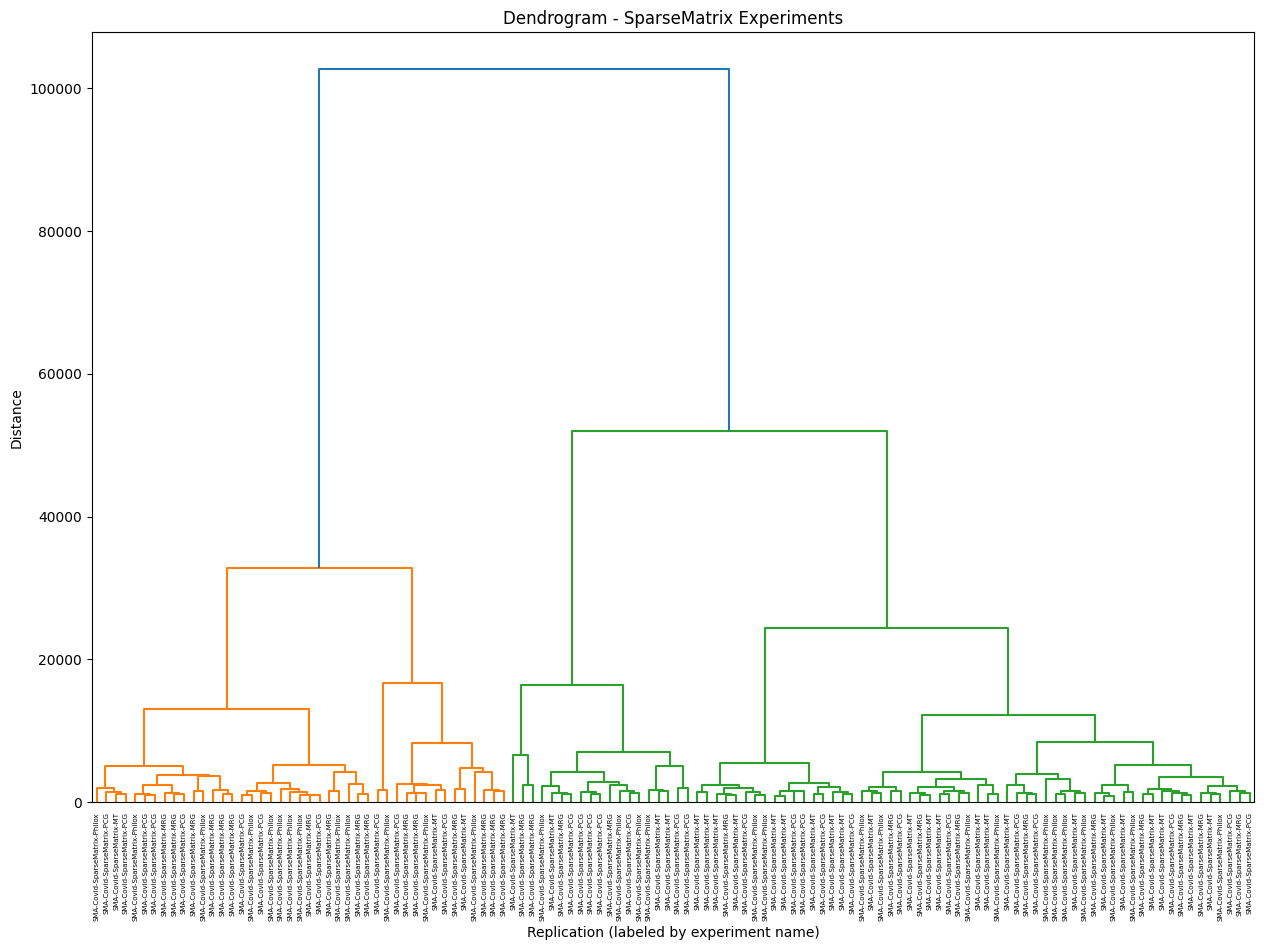

Cluster 1:
  SMA-Covid-SparseMatrix-MRG: 34.48%
  SMA-Covid-SparseMatrix-MT: 3.45%
  SMA-Covid-SparseMatrix-PCG: 27.59%
  SMA-Covid-SparseMatrix-Philox: 34.48%
Cluster 5:
  SMA-Covid-SparseMatrix-MRG: 21.95%
  SMA-Covid-SparseMatrix-MT: 34.15%
  SMA-Covid-SparseMatrix-PCG: 17.07%
  SMA-Covid-SparseMatrix-Philox: 26.83%
Cluster 3:
  SMA-Covid-SparseMatrix-MRG: 21.05%
  SMA-Covid-SparseMatrix-MT: 21.05%
  SMA-Covid-SparseMatrix-PCG: 36.84%
  SMA-Covid-SparseMatrix-Philox: 21.05%
Cluster 2:
  SMA-Covid-SparseMatrix-MRG: 42.86%
  SMA-Covid-SparseMatrix-MT: 14.29%
  SMA-Covid-SparseMatrix-PCG: 21.43%
  SMA-Covid-SparseMatrix-Philox: 21.43%
Cluster 4:
  SMA-Covid-SparseMatrix-MRG: 5.88%
  SMA-Covid-SparseMatrix-MT: 52.94%
  SMA-Covid-SparseMatrix-PCG: 29.41%
  SMA-Covid-SparseMatrix-Philox: 11.76%


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Filter for experiments with "SparseMatrix" in their name
sparse_matrix_indices = [i for i, name in enumerate(base_dirs) if "SparseMatrix" in name]
sparse_matrix_names = [base_dirs[i] for i in sparse_matrix_indices]

# Extract the corresponding time series data for SparseMatrix experiments
sparse_matrix_data = []
sparse_matrix_experiment_labels = []
for idx in sparse_matrix_indices:
    for j in range(NB_REPLICATION):
        sparse_matrix_data.append(all_nb_nouv_cas_np[idx * NB_REPLICATION + j])
        sparse_matrix_experiment_labels.append(sparse_matrix_names[sparse_matrix_indices.index(idx)])

# Perform hierarchical clustering with Euclidean distance
sparse_matrix_linkage = linkage(sparse_matrix_data, method='ward', metric='euclidean')

# Plot the dendrogram and label each replication with the experiment name
plt.figure(figsize=(15, 10))
dendrogram(sparse_matrix_linkage, labels=sparse_matrix_experiment_labels, leaf_rotation=90)
plt.title("Dendrogram - SparseMatrix Experiments")
plt.xlabel("Replication (labeled by experiment name)")
plt.ylabel("Distance")
plt.show()

# Automatically detect clusters and count the proportion of each experiment type
threshold = 20000  # Set an appropriate threshold for cutting the dendrogram
cluster_labels = fcluster(sparse_matrix_linkage, threshold, criterion='distance')

# Count the proportion of each experiment type in each cluster
from collections import defaultdict, Counter

cluster_experiment_counts = defaultdict(Counter)

for cluster, label in zip(cluster_labels, sparse_matrix_experiment_labels):
    cluster_experiment_counts[cluster][label] += 1

# Print the proportion of each experiment type in each cluster
for cluster, counts in cluster_experiment_counts.items():
    total = sum(counts.values())
    print(f"Cluster {cluster}:")
    #print(counts)
    for experiment, count in counts.items():
        proportion = count / total
        print(f"  {experiment}: {proportion:.2%}")

In [24]:
"""
The hierarchical clustering algorithm and the function fcluster for cutting the dendrogram at a specific threshold are based on well-established mathematical principles and theorems. Below is a detailed explanation of the mathematical foundations of these methods:
Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. The process involves the following key steps and concepts:

    Distance Metric:
        In this example, Euclidean distance is used, defined as:
        d(x,y)=∑i=1n(xi−yi)2
        d(x,y)=i=1∑n​(xi​−yi​)2

        ​

    where xx and yy are n-dimensional vectors.

    Linkage Criteria:
        The Ward's method (used in the linkage function) is an agglomerative hierarchical clustering method. It minimizes the total within-cluster variance. At each step, the pair of clusters with the smallest increase in total within-cluster variance after merging is chosen. The increase in variance can be computed as:
        ΔE=∣C1∣⋅∣C2∣∣C1∣+∣C2∣⋅∥xˉ1−xˉ2∥2
        ΔE=∣C1​∣+∣C2​∣∣C1​∣⋅∣C2​∣​⋅∥xˉ1​−xˉ2​∥2

    where C1C1​ and C2C2​ are clusters to be merged, ∣Ci∣∣Ci​∣ is the size (number of points) of cluster ii, and xˉixˉi​ is the centroid of cluster ii.

    Linkage Matrix:
        The linkage matrix is a data structure that records the hierarchical clustering. It is an (n−1)×4(n−1)×4 matrix where nn is the number of observations. Each row represents a merge, containing the indices of the merged clusters, the distance between the clusters, and the number of points in the new cluster.

Cutting the Dendrogram

To form flat clusters from the hierarchical tree, you can "cut" the dendrogram at a specified threshold. This process is mathematically described as follows:

    Dendrogram Cutting:
        The function fcluster cuts the dendrogram at a given height (threshold) to form flat clusters. The criterion for cutting can be defined by distance or inconsistency. Here, we use the distance criterion.

    Cluster Formation:
        A flat cluster is formed by collecting all the points that are connected without any linkage exceeding the specified threshold.

Mathematical Theorem: Ward's Minimum Variance Method

The mathematical foundation of Ward's method is based on the objective of minimizing the total within-cluster variance, which can be stated as:

Theorem:
Given a set of observations, {x1,x2,...,xn}{x1​,x2​,...,xn​}, and a partition of these observations into kk clusters, C1,C2,...,CkC1​,C2​,...,Ck​, Ward's method seeks to minimize the total within-cluster variance EE, defined as:
E=∑j=1k∑xi∈Cj∥xi−xˉj∥2
E=j=1∑k​xi​∈Cj​∑​∥xi​−xˉj​∥2

where xˉjxˉj​ is the centroid of cluster CjCj​.
Proportional Analysis of Clusters

After forming clusters using hierarchical clustering, the proportions of different types of experiments within each cluster are calculated based on simple counting and proportion formulas.

Mathematical Formulation:
For a cluster CC containing nCnC​ replications, where nPCGnPCG​, nMRGnMRG​, nPhiloxnPhilox​, and nMTnMT​ are the counts of replications from the PCG, MRG, Philox, and MT experiments respectively, the proportion of each experiment type in the cluster is given by:
ProportionPCG=nPCGnC,ProportionMRG=nMRGnC,ProportionPhilox=nPhiloxnC,ProportionMT=nMTnC
ProportionPCG​=nC​nPCG​​,ProportionMRG​=nC​nMRG​​,ProportionPhilox​=nC​nPhilox​​,ProportionMT​=nC​nMT​​

This allows you to analyze the composition of each cluster in terms of the different types of experiments.







Mathematical Documentation for Hierarchical Clustering and Proportion Analysis
Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. It can be divided into two main types: agglomerative and divisive. Agglomerative clustering starts with each observation as its own cluster and iteratively merges the most similar clusters until a single cluster is formed. Divisive clustering starts with all observations in a single cluster and splits them iteratively into smaller clusters.

In the provided code, we are using agglomerative hierarchical clustering with the Ward linkage method and Euclidean distance. The underlying mathematical concepts and Python functions used are described below:
Distance Metric: Euclidean Distance

The Euclidean distance between two points x=(x1,x2,...,xn)x=(x1​,x2​,...,xn​) and y=(y1,y2,...,yn)y=(y1​,y2​,...,yn​) in n-dimensional space is given by:
d(x,y)=∑i=1n(xi−yi)2
d(x,y)=i=1∑n​(xi​−yi​)2
​

In Python, this is calculated using the metric='euclidean' parameter in the linkage function.
Linkage Criteria: Ward's Method

Ward's method seeks to minimize the total within-cluster variance. At each step, the pair of clusters that leads to the minimum increase in total within-cluster variance after merging is chosen. This increase in variance can be computed as:
ΔE=∣C1∣⋅∣C2∣∣C1∣+∣C2∣⋅∥xˉ1−xˉ2∥2
ΔE=∣C1​∣+∣C2​∣∣C1​∣⋅∣C2​∣​⋅∥xˉ1​−xˉ2​∥2

where:

    C1C1​ and C2C2​ are clusters to be merged,
    ∣Ci∣∣Ci​∣ is the size (number of points) of cluster ii,
    xˉixˉi​ is the centroid of cluster ii.

In Python, this is implemented using method='ward' in the linkage function.
Linkage Matrix

The linkage matrix is an (n−1)×4(n−1)×4 matrix where nn is the number of observations. Each row of the matrix represents a merge. The columns represent:

    The indices of the clusters that were merged.
    The distance between the merged clusters.
    The number of original observations in the newly formed cluster.

The linkage function in Python generates this matrix.



Dendrogram

A dendrogram is a tree-like diagram that records the sequences of merges or splits. The vertical axis represents the distance or dissimilarity at which clusters are merged. The horizontal axis represents the individual observations.

In Python, the dendrogram function is used to create this plot.



Cutting the Dendrogram: Flat Clustering

To form flat clusters from the hierarchical tree, we cut the dendrogram at a specified threshold. The fcluster function is used to achieve this, which assigns a cluster label to each observation.



Proportional Analysis of Clusters

After forming clusters using hierarchical clustering, we can analyze the composition of each cluster. This involves counting the occurrences of different experiment types within each cluster and calculating their proportions.
Counting Occurrences

For each cluster, we count the occurrences of each experiment type. This can be done using a Counter from the collections module.



Calculating Proportions

The proportion of each experiment type within a cluster is calculated by dividing the count of that experiment type by the total number of observations in the cluster.
Proportionexperiment=Count of experiment typeTotal number of observations in cluster
Proportionexperiment​=Total number of observations in clusterCount of experiment type​
"""

'\nThe hierarchical clustering algorithm and the function fcluster for cutting the dendrogram at a specific threshold are based on well-established mathematical principles and theorems. Below is a detailed explanation of the mathematical foundations of these methods:\nHierarchical Clustering\n\nHierarchical clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. The process involves the following key steps and concepts:\n\n    Distance Metric:\n        In this example, Euclidean distance is used, defined as:\n        d(x,y)=∑i=1n(xi−yi)2\n        d(x,y)=i=1∑n\u200b(xi\u200b−yi\u200b)2\n\n        \u200b\n\n    where xx and yy are n-dimensional vectors.\n\n    Linkage Criteria:\n        The Ward\'s method (used in the linkage function) is an agglomerative hierarchical clustering method. It minimizes the total within-cluster variance. At each step, the pair of clusters with the smallest increase in total within-cluster variance after merging is chosen. The

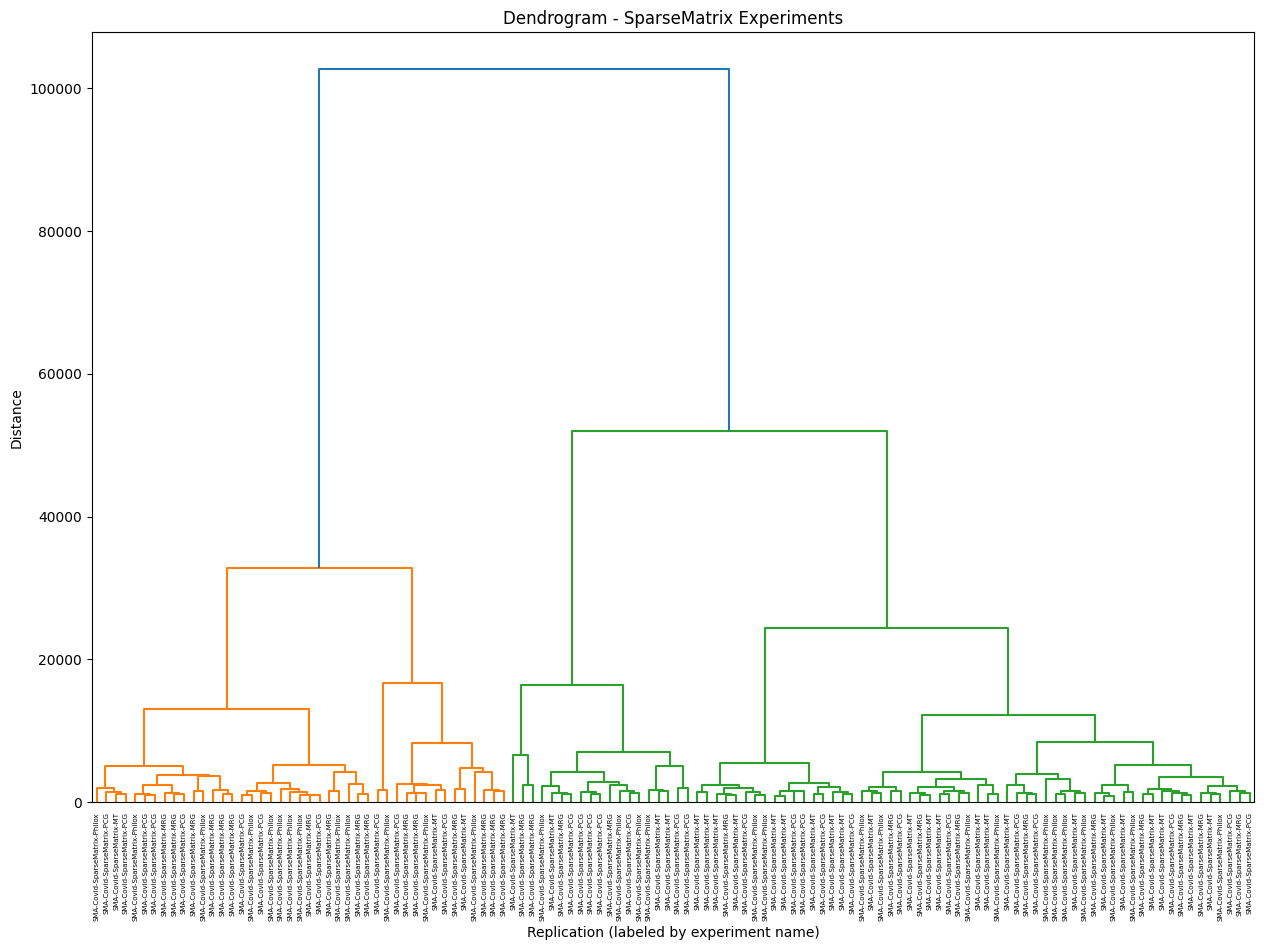

Cluster 2:
  SMA-Covid-SparseMatrix-MRG: 28.57%
  SMA-Covid-SparseMatrix-PCG: 21.43%
  SMA-Covid-SparseMatrix-Philox: 50.00%
Cluster 1:
  SMA-Covid-SparseMatrix-MRG: 40.00%
  SMA-Covid-SparseMatrix-MT: 6.67%
  SMA-Covid-SparseMatrix-PCG: 33.33%
  SMA-Covid-SparseMatrix-Philox: 20.00%
Cluster 9:
  SMA-Covid-SparseMatrix-MRG: 23.08%
  SMA-Covid-SparseMatrix-MT: 30.77%
  SMA-Covid-SparseMatrix-PCG: 19.23%
  SMA-Covid-SparseMatrix-Philox: 26.92%
Cluster 6:
  SMA-Covid-SparseMatrix-MRG: 12.50%
  SMA-Covid-SparseMatrix-MT: 18.75%
  SMA-Covid-SparseMatrix-PCG: 43.75%
  SMA-Covid-SparseMatrix-Philox: 25.00%
Cluster 4:
  SMA-Covid-SparseMatrix-MRG: 50.00%
  SMA-Covid-SparseMatrix-MT: 16.67%
  SMA-Covid-SparseMatrix-PCG: 16.67%
  SMA-Covid-SparseMatrix-Philox: 16.67%
Cluster 5:
  SMA-Covid-SparseMatrix-MRG: 66.67%
  SMA-Covid-SparseMatrix-MT: 33.33%
Cluster 8:
  SMA-Covid-SparseMatrix-MRG: 20.00%
  SMA-Covid-SparseMatrix-MT: 40.00%
  SMA-Covid-SparseMatrix-PCG: 13.33%
  SMA-Covid-SparseMatrix-Ph

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Filter for experiments with "SparseMatrix" in their name
sparse_matrix_indices = [i for i, name in enumerate(base_dirs) if "SparseMatrix" in name]
sparse_matrix_names = [base_dirs[i] for i in sparse_matrix_indices]

# Extract the corresponding time series data for SparseMatrix experiments
sparse_matrix_data = []
sparse_matrix_experiment_labels = []
for idx in sparse_matrix_indices:
    for j in range(NB_REPLICATION):
        sparse_matrix_data.append(all_nb_nouv_cas_np[idx * NB_REPLICATION + j])
        sparse_matrix_experiment_labels.append(sparse_matrix_names[sparse_matrix_indices.index(idx)])

# Perform hierarchical clustering with Euclidean distance
sparse_matrix_linkage = linkage(sparse_matrix_data, method='ward', metric='euclidean')

# Plot the dendrogram and label each replication with the experiment name
plt.figure(figsize=(15, 10))
dendrogram(sparse_matrix_linkage, labels=sparse_matrix_experiment_labels, leaf_rotation=90)
plt.title("Dendrogram - SparseMatrix Experiments")
plt.xlabel("Replication (labeled by experiment name)")
plt.ylabel("Distance")
plt.show()

# Automatically detect clusters and count the proportion of each experiment type
threshold = 10000  # Set an appropriate threshold for cutting the dendrogram
cluster_labels = fcluster(sparse_matrix_linkage, threshold, criterion='distance')

# Count the proportion of each experiment type in each cluster
from collections import defaultdict, Counter

cluster_experiment_counts = defaultdict(Counter)

for cluster, label in zip(cluster_labels, sparse_matrix_experiment_labels):
    cluster_experiment_counts[cluster][label] += 1

# Print the proportion of each experiment type in each cluster
for cluster, counts in cluster_experiment_counts.items():
    total = sum(counts.values())
    print(f"Cluster {cluster}:")
    #print(counts)
    for experiment, count in counts.items():
        proportion = count / total
        print(f"  {experiment}: {proportion:.2%}")

In [26]:
#### STAGE 2 : Sensitivity analysis on different parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




"""
I have 6 different varying parameters.
[0,0,0,0,0,0]
All have 3 possible values, expect the last, 5 values.

I will map corresponding couple of parameters with a list.
The index of the list correspond to the parameters:
index 0 = histogram_contamination_variants
index 1 = asymptomatic
index 2 = resistance_reinfection
index 3 = max_resistance_vaccin and min_resistance_vaccin
index 4 = timeline_vaccination
index 5 = nb_deplacement_jour

And the value at this index correspond to the value of the paramters.
For example :
[0,0,1,2,2,4] correspond to :
 - histogram_contamination_variants : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.4, 0.2]
 - asymptomatic : 0.2
 - resistance_reinfection :[0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.4, 0.3]
 - max_resistance_vaccin : [0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.1]
 - timeline_vaccination = ["1,90"]
 - nb_deplacement_jour : 30
 
 
I have 243 configVaccin files : configVaccin_variant_[1-243].txt
I have 5 configDpt75 files : configDpt75_variant_[1-5].txt

The log files, after computation, are named with the following pattern :
log-configVaccin_variant_[1-243].txt-configDpt75_variant_[1-5].txt-MT-mts000M00000[0-2]NumRepli[0-2].txt

Each experiment has 3 replications, this correspond to mts000M00000[0-2] and NumRepli[0-2]

I need to associate each log file with a list the indicates the parameters used, as shown for example before [0,0,1,2,2,2,4]
To do this, I need to look in configVaccin files and configDpt75 files the corresponding values of each parameters.
I can search for the string "parametersName||values".
So, I will have a map, mapping a log file to a corresponding list.
The configVaccin and configDpt75 files are inside the folder "SMA-Covid-V2-ZZ3-MT-PlanExperience"

Let's make a table (or dataframe), with first columns being the name of the experiment 
([0,0,1,2,2,4]-variantVaccin[1-243]-variantDpt[1-5])
I will add some columns later, for repli1 value, repli2 value, repli3 value, mean, for a X variable.

"""

# Define possible values for the variables
#In the file configVaccin : "defaultVariantHistoConta||0.3, 0.4, 0.5,...." , 3 possibles values
histogram_contamination_variants = [
    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.4, 0.2],
    [0.7, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.7, 0.5, 0.3],
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.6, 0.4, 0.2, 0.1]
]
#################
#In the file configVaccin : "pourcentAsymptomatique||0.2" , 3 possible values
asymptomatic = [0.2, 0.5, 0.8]
###############
#In the file configVaccin : resistanceInfectionValuesByAge||, 3 possible values
resistance_reinfection = [
    [0.999, 0.999, 0.999, 0.999, 0.99, 0.90, 0.80, 0.70],
    [0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.4, 0.3],
    [0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.1, 0.1]
]
##################
#In the file configVaccin : maxResistanceInjectionValuesByAge|| and min, 3 possible values
max_resistance_vaccin = [
    [0.8, 0.8, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4],
    [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
    [0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.1]
]
min_resistance_vaccin = [
    [0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3],
    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
]
####################
# timelineVaccination||
timeline_vaccination = [[1,10],[1,50],[1,90]]
##################
#In the file configDpt75 : nbDeplacementJour||, 5 possible values
nb_deplacement_jour = [1, 5, 10, 20, 30]
###########




In [2]:
import os
import re
import numpy as np
import pandas as pd

# Path to the directory containing the config files
config_dir = "SMA-Covid-V2-ZZ3-MT-PlanExperience"

# Function to read and parse a config file
def parse_config_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    parameters = {}
    for line in content.split('\n'):
        if "||" in line:
            key, value = line.split("||")
            value = value.strip()
            if ',' in value:
                value = [float(v) for v in value.split(',') if v]
            elif value:
                value = float(value)
            parameters[key.strip()] = value
    return parameters

# Reading configVaccin files
config_vaccin_files = [f"configVaccin_variant_{i}.txt" for i in range(1, 244)]
config_vaccin_data = {}
for file_name in config_vaccin_files:
    file_path = os.path.join(config_dir, file_name)
    config_vaccin_data[file_name] = parse_config_file(file_path)

# Reading configDpt75 files
config_dpt75_files = [f"configDpt75_variant_{i}.txt" for i in range(1, 6)]
config_dpt75_data = {}
for file_name in config_dpt75_files:
    file_path = os.path.join(config_dir, file_name)
    config_dpt75_data[file_name] = parse_config_file(file_path)

# Function to get parameter index from value
def get_param_index(value, param_list):
    for i, param_value in enumerate(param_list):
        if param_value == value:
            return i
    return -1

# Create a dictionary to store the mapping
log_to_params = {}


# Parse the log file names and map to parameter lists
log_files = [f"log-configVaccin_variant_{i}.txt-configDpt75_variant_{j}.txt-MT-mts000M00000{k}NumRepli{l}.txt"
             for i in range(1, 244) for j in range(1, 6) for k in range(3) for l in range(3)]

for log_file in log_files:
    vaccin_index = int(re.search(r'configVaccin_variant_(\d+).txt', log_file).group(1)) - 1
    dpt_index = int(re.search(r'configDpt75_variant_(\d+).txt', log_file).group(1)) - 1
    
    vaccin_params = config_vaccin_data[f"configVaccin_variant_{vaccin_index + 1}.txt"]
    dpt_params = config_dpt75_data[f"configDpt75_variant_{dpt_index + 1}.txt"]
    
    param_list = [
        get_param_index(vaccin_params["defaultVariantHistoConta"], histogram_contamination_variants),
        get_param_index(vaccin_params["pourcentAsymptomatique"], asymptomatic),
        get_param_index(vaccin_params["resistanceInfectionValuesByAge"], resistance_reinfection),
        get_param_index(vaccin_params["maxResistanceInjectionValuesByAge"], max_resistance_vaccin),
        get_param_index(vaccin_params["timelineVaccination"], timeline_vaccination),
        get_param_index(dpt_params["nbDeplacementJour"], nb_deplacement_jour)
    ]
    
    
    experiment_name = f"{param_list}-variantVaccin{vaccin_index + 1}-variantDpt{dpt_index + 1}"
    log_to_params[experiment_name] = param_list

# Create a DataFrame
df = pd.DataFrame(list(log_to_params.items()), columns=['ExperimentName', 'Parameters'])



df



ExperimentName          Parameters
0       [0, 0, 0, 0, 0, 0]-variantVaccin1-variantDpt1  [0, 0, 0, 0, 0, 0]
1       [0, 0, 0, 0, 0, 1]-variantVaccin1-variantDpt2  [0, 0, 0, 0, 0, 1]
2       [0, 0, 0, 0, 0, 2]-variantVaccin1-variantDpt3  [0, 0, 0, 0, 0, 2]
3       [0, 0, 0, 0, 0, 3]-variantVaccin1-variantDpt4  [0, 0, 0, 0, 0, 3]
4       [0, 0, 0, 0, 0, 4]-variantVaccin1-variantDpt5  [0, 0, 0, 0, 0, 4]
...                                               ...                 ...
1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1  [2, 2, 2, 2, 2, 0]
1211  [2, 2, 2, 2, 2, 1]-variantVaccin243-variantDpt2  [2, 2, 2, 2, 2, 1]
1212  [2, 2, 2, 2, 2, 2]-variantVaccin243-variantDpt3  [2, 2, 2, 2, 2, 2]
1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4  [2, 2, 2, 2, 2, 3]
1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5  [2, 2, 2, 2, 2, 4]

[1215 rows x 2 columns]

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Define constants
NB_REPLICATION = 3
NOM_EXPERIENCE = "configVaccin"
listDptConfig = ["configDpt75_variant_1", "configDpt75_variant_2", "configDpt75_variant_3", "configDpt75_variant_4", "configDpt75_variant_5"]
#listDptConfig = ["configDpt75_variant_1"] #Testing purpose
base_dirs = ["SMA-Covid-V2-ZZ3-MT-PlanExperience"]

# Function to extract data from log files
def extract_experiment_results(folder, vaccin_variant, dpt_variant, repl_num):
    file_path = os.path.join(folder, f"log-{NOM_EXPERIENCE}_variant_{vaccin_variant}.txt-{dpt_variant}.txt-MT-mts000M00000{repl_num}NumRepli{repl_num}.txt")
    
    nbCasCovidConnuTotal = 0
    nbMortTotal = 0
    nbHumainSimuDepart = 0
    listNbNouvCas = []
    epidemicDuration = 0
    listNumIteration = []
    listNbNouvCas = []
    listNbPersonneHosp = []
    listNbPersonneRea = []
    listNbNouvHosp = []
    listNbNouvRea = []
    listNbNouvMort = []
    listAgeMort = []
    listAgeNouvCasSymptomatique = []
    listReffectif = []
    listTauxIncidence = []
    nbRandomGenere = 0
    

    with open(file_path, 'r') as f:
        lines = f.readlines()
        print(f)
        i = 0
        for line in lines:
            if "CompteurRand:" in line:
                listSplit = line.split(":")
                nbRandomGenere = int(listSplit[1])
            elif "NbHumainSimuDepart:" in line:
                listSplit = line.split(":")
                nbHumainSimuDepart = int(listSplit[1])
            elif "##" not in line:
                if i == 0:
                    listNumIteration.append(int(line))
                    i += 1
                elif i == 1:
                    listNbNouvCas.append(int(line))
                    if(int(line) > 0):
                        epidemicDuration += 1
                    i += 1
                elif i == 2:
                    listNbPersonneHosp.append(int(line))
                    i += 1
                elif i == 3:
                    listNbPersonneRea.append(int(line))
                    i += 1
                elif i == 4:
                    listNbNouvHosp.append(int(line))
                    i += 1
                elif i == 5:
                    listNbNouvRea.append(int(line))
                    i += 1
                elif i == 6:
                    listNbNouvMort.append(int(line))
                    i += 1
                elif i == 7:
                    nbCasCovidConnuTotal = int(line)
                    i += 1
                elif i == 8:
                    listReffectif.append(float(line))
                    i += 1
                elif i == 9:
                    listTauxIncidence.append(float(line))
                    i += 1
                elif "AgeC:" in line:
                    listSplit = line.split(":")
                    listAgeNouvCasSymptomatique.append(int(listSplit[1]))
                elif "AgeD:" in line:
                    listSplit = line.split(":")
                    listAgeMort.append(int(listSplit[1]))
            else:
                i = 0
    
    nbMortTotal = sum(listNbNouvMort)
    try:
        tauxDeMortCasConnu = (nbMortTotal / nbCasCovidConnuTotal) * 100
    except ZeroDivisionError:
        tauxDeMortCasConnu = 0
    tauxMortalitePopulationGlobale = (nbMortTotal / nbHumainSimuDepart) * 100
    
    age_categories = [0, 0, 0, 0, 0, 0, 0, 0]
    for age in listAgeNouvCasSymptomatique:
        age_categories[age] += 1

    age_mort_categories = [0, 0, 0, 0, 0, 0, 0, 0]
    for age in listAgeMort:
        age_mort_categories[age] += 1
    
    age_mortality_rates = []
    for mort, total in zip(age_mort_categories, age_categories):
        try:
            age_mortality_rates.append((mort / total) * 100)
        except ZeroDivisionError:
            age_mortality_rates.append(0)
    
    #I return only what is useful for my study
    return [nbCasCovidConnuTotal,nbMortTotal,  epidemicDuration, tauxDeMortCasConnu, tauxMortalitePopulationGlobale]


# Function to process all experiments and compile results into DataFrame
def process_experiments(df):
    results_summary = []

    for folder in base_dirs:
        for dpt_variant in listDptConfig:
            for vaccin_variant in range(1, 244):  #Assuming 243 variants
                replications = []
                for repl_num in range(NB_REPLICATION):
                    results = extract_experiment_results(folder, vaccin_variant, dpt_variant, repl_num)
                    replications.append(results)
                
                # Calculate mean and standard deviation for each metric
                replications = np.array(replications, dtype=np.float64)
                means = np.nanmean(replications, axis=0)
                std_devs = np.nanstd(replications, axis=0)
                
                                
                # Find the corresponding row in the existing DataFrame and update it
                experiment_mask = df['ExperimentName'].str.contains(f"variantVaccin{vaccin_variant}") & df['ExperimentName'].str.contains(f"variantDpt{dpt_variant[-1]}")
                df.loc[experiment_mask, 'nbCasCovidConnuTotal-repli1'] = replications[0, 0]
                df.loc[experiment_mask, 'nbCasCovidConnuTotal-repli2'] = replications[1, 0]
                df.loc[experiment_mask, 'nbCasCovidConnuTotal-repli3'] = replications[2, 0]
                df.loc[experiment_mask, 'nbCasCovidConnuTotal-Mean'] = means[0]
                df.loc[experiment_mask, 'nbCasCovidConnuTotal-Std'] = std_devs[0]
                
                df.loc[experiment_mask, 'nbMortTotal-repli1'] = replications[0, 1]
                df.loc[experiment_mask, 'nbMortTotal-repli2'] = replications[1, 1]
                df.loc[experiment_mask, 'nbMortTotal-repli3'] = replications[2, 1]
                df.loc[experiment_mask, 'nbMortTotal-Mean'] = means[1]
                df.loc[experiment_mask, 'nbMortTotal-Std'] = std_devs[1]
                
                df.loc[experiment_mask, 'epidemicDuration-repli1'] = replications[0, 2]
                df.loc[experiment_mask, 'epidemicDuration-repli2'] = replications[1, 2]
                df.loc[experiment_mask, 'epidemicDuration-repli3'] = replications[2, 2]
                df.loc[experiment_mask, 'epidemicDuration-Mean'] = means[2]
                df.loc[experiment_mask, 'epidemicDuration-Std'] = std_devs[2]
                
                df.loc[experiment_mask, 'tauxDeMortCasConnu-repli1'] = replications[0, 3]
                df.loc[experiment_mask, 'tauxDeMortCasConnu-repli2'] = replications[1, 3]
                df.loc[experiment_mask, 'tauxDeMortCasConnu-repli3'] = replications[2, 3]
                df.loc[experiment_mask, 'tauxDeMortCasConnu-Mean'] = means[3]
                df.loc[experiment_mask, 'tauxDeMortCasConnu-Std'] = std_devs[3]
                
                df.loc[experiment_mask, 'tauxMortalitePopulationGlobale-repli1'] = replications[0, 4]
                df.loc[experiment_mask, 'tauxMortalitePopulationGlobale-repli2'] = replications[1, 4]
                df.loc[experiment_mask, 'tauxMortalitePopulationGlobale-repli3'] = replications[2, 4]
                df.loc[experiment_mask, 'tauxMortalitePopulationGlobale-Mean'] = means[4]
                df.loc[experiment_mask, 'tauxMortalitePopulationGlobale-Std'] = std_devs[4]

    return df

# Assume `df` is the existing DataFrame created earlier
# Add columns for each of the metrics and their replications, means, and standard deviations
metrics = [
    'nbCasCovidConnuTotal', 'nbMortTotal', 'epidemic_duration',
    'tauxDeMortCasConnu', 'tauxMortalitePopulationGlobale'
]
for metric in metrics:
    for repl in range(1, NB_REPLICATION + 1):
        df[f'{metric}-repli{repl}'] = np.nan
    df[f'{metric}-Mean'] = np.nan
    df[f'{metric}-Std'] = np.nan

# Run the processing function to update the DataFrame
df_summary = process_experiments(df)

df_summary

df_summary.to_csv("fullDfPlanExperience-Results.csv")

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_2.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_2.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_2.txt-configDpt75_variant_1.txt-MT-mts00

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_30.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_30.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_30.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_31.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_31.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_31.txt-configDpt75_variant_1.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_53.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_53.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_53.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_54.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_54.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_54.txt-configDpt75_variant_1.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_70.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_72.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_72.txt-configDpt75_variant_1.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_88.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_89.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_89.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_89.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_90.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_90.txt-configDpt75_variant_1.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_106.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_106.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_107.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_107.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_107.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_108.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_123.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_123.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_123.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_137.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_139.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_139.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_153.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_153.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_154.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_154.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_154.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_155.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_204.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_205.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_205.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_205.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_206.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_206.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_1.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_234.txt-configDpt75_variant_1.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_234.txt-configDpt75_variant_1.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_234.txt-configDpt75_variant_1.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_7.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_7.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_8.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_8.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_8.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_9.txt-configDpt75_variant_2.txt-MT-mts00

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_23.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_23.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_23.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_24.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_24.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_24.txt-configDpt75_variant_2.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_38.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_39.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_39.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_39.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_40.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_40.txt-configDpt75_variant_2.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_54.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_54.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_55.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_55.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_55.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_56.txt-configDpt75_variant_2.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_70.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_70.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_70.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_71.txt-configDpt75_variant_2.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_85.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_86.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_86.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_86.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_87.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_87.txt-configDpt75_variant_2.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_101.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_101.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_102.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_102.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_102.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_103.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_117.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_117.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_117.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_118.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_118.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_118.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_133.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_133.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_133.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_134.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_134.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_134.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_148.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_149.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_149.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_149.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_150.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_150.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_172.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_172.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_172.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_173.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_173.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_173.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_211.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_212.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_212.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_212.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_213.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_213.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_227.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_227.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_228.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_228.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_228.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_229.txt-configDpt75_variant_2.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_243.txt-configDpt75_variant_2.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_243.txt-configDpt75_variant_2.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_243.txt-configDpt75_variant_2.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_1.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_16.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_16.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_16.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_17.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_17.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_17.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_31.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_32.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_32.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_32.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_33.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_33.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_47.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_47.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_48.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_48.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_48.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_49.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_63.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_63.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_63.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_64.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_64.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_64.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_79.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_79.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_79.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_80.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_80.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_80.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_94.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_95.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_95.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_95.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_96.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_96.txt-configDpt75_variant_3.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_110.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_110.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_111.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_111.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_111.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_112.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_126.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_126.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_126.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_127.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_127.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_127.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_141.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_142.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_142.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_142.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_143.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_143.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_157.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_157.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_158.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_158.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_158.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_159.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_175.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_175.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_176.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_176.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_176.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_191.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_191.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_191.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_206.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_207.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_207.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_207.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_208.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_208.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_223.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_223.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_225.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_239.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_239.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_239.txt-configDpt75_variant_3.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_3.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_3.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_3.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_11.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_12.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_12.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_12.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_13.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_13.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_27.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_27.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_28.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_28.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_28.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_29.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_43.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_43.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_43.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_44.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_44.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_44.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_58.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_59.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_59.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_59.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_60.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_60.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_74.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_74.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_75.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_75.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_75.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_76.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_90.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_90.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_90.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_91.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_91.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_91.txt-configDpt75_variant_4.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_105.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_106.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_106.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_106.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_107.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_107.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_121.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_121.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_122.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_123.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_137.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_137.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_137.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_138.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_152.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_153.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_153.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_153.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_154.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_154.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_169.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_169.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_170.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_170.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_170.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_171.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_185.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_185.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_185.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_186.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_186.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_186.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_200.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_201.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_201.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_201.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_202.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_202.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_216.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_216.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_217.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_217.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_217.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_218.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_232.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_232.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_232.txt-configDpt75_variant_4.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_4.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_4.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_233.txt-configDpt75_variant_4.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_4.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_5.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_5.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_5.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_6.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_6.txt-configDpt75_variant_5.txt-MT-mts00

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_20.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_20.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_21.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_21.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_21.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_22.txt-configDpt75_variant_5.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_36.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_36.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_36.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_37.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_37.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_37.txt-configDpt75_variant_5.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_51.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_52.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_52.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_52.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_53.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_53.txt-configDpt75_variant_5.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_67.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_67.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_68.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_68.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_68.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_69.txt-configDpt75_variant_5.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_83.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_83.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_83.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_84.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_84.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_84.txt-configDpt75_variant_5.txt-MT

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_98.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_99.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_99.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_99.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_100.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_100.txt-configDpt75_variant_5.txt-

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_114.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_114.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_115.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_115.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_115.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_116.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_130.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_130.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_130.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_131.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_131.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_131.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_145.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_146.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_146.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_146.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_147.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_147.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_161.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_161.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_162.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_162.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_162.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_163.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_177.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_178.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_192.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_193.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_194.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_194.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_208.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_208.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_209.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_209.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_209.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_210.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_224.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_225.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_225.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_225.txt-configDpt75_variant_5.

<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_239.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_5.txt-MT-mts000M000001NumRepli1.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_240.txt-configDpt75_variant_5.txt-MT-mts000M000002NumRepli2.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_241.txt-configDpt75_variant_5.txt-MT-mts000M000000NumRepli0.txt' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='SMA-Covid-V2-ZZ3-MT-PlanExperience/log-configVaccin_variant_241.txt-configDpt75_variant_5.

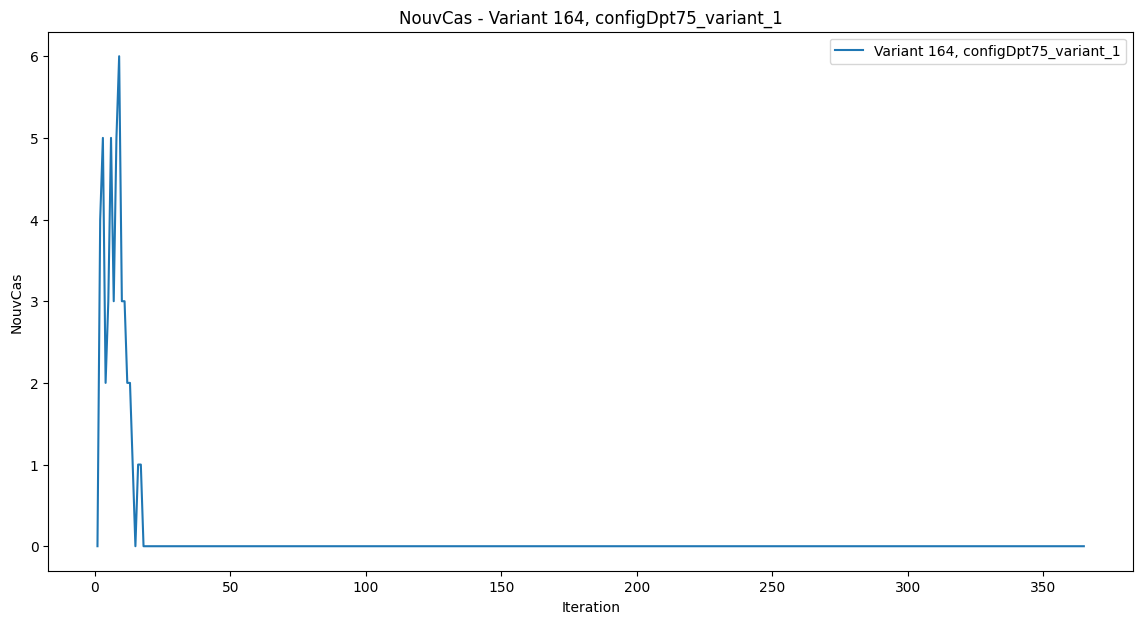

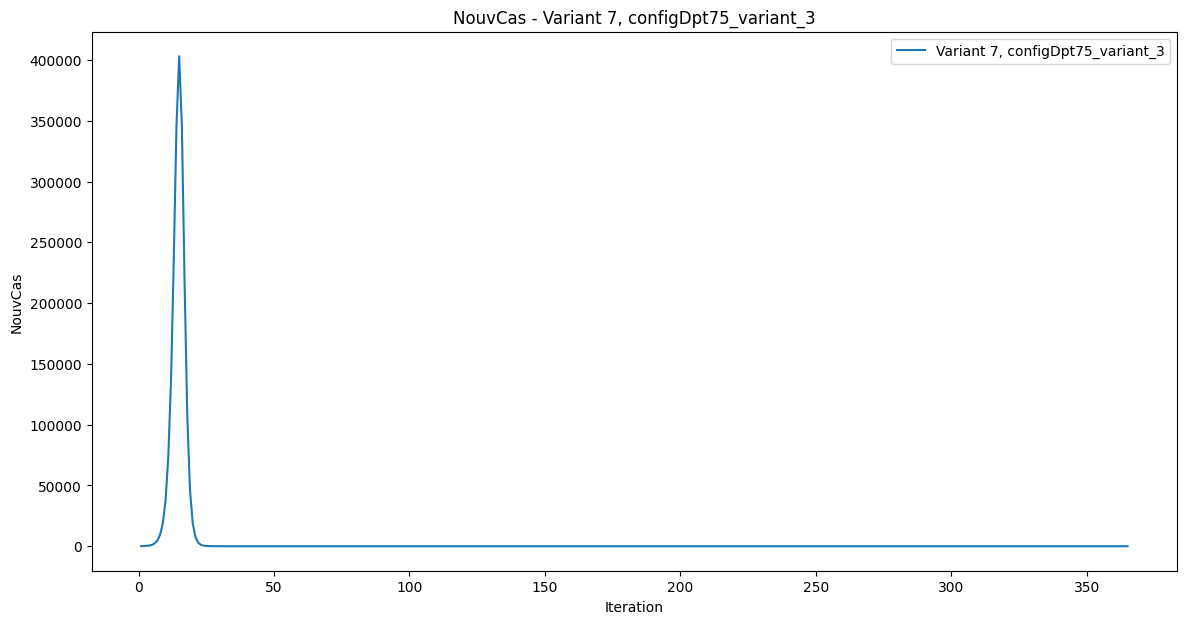

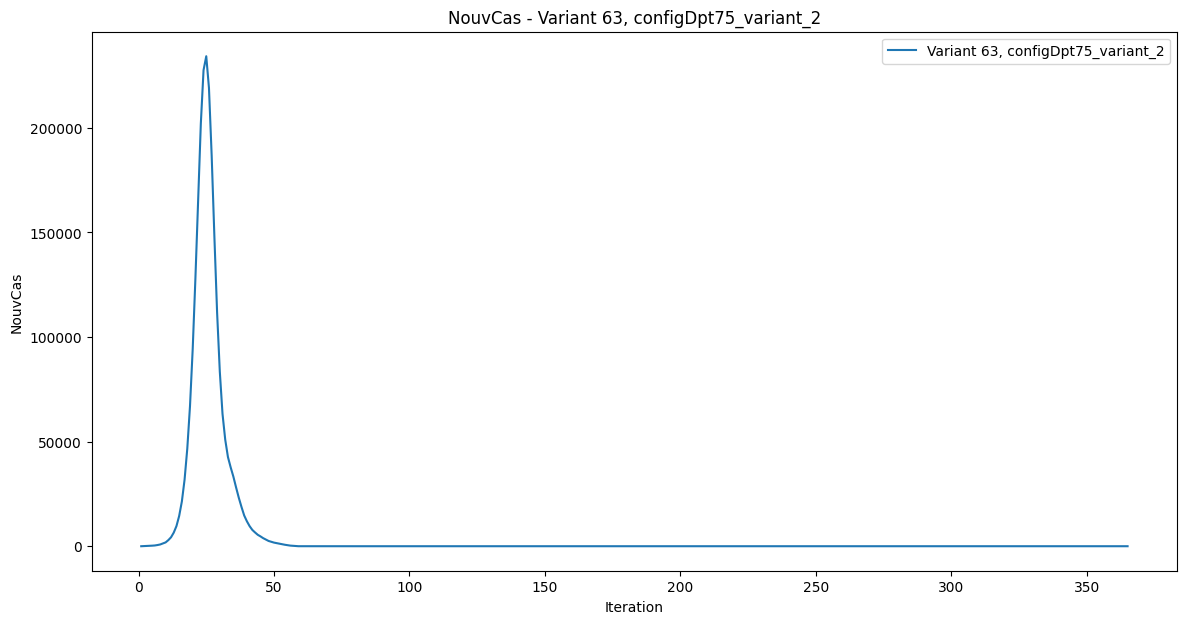

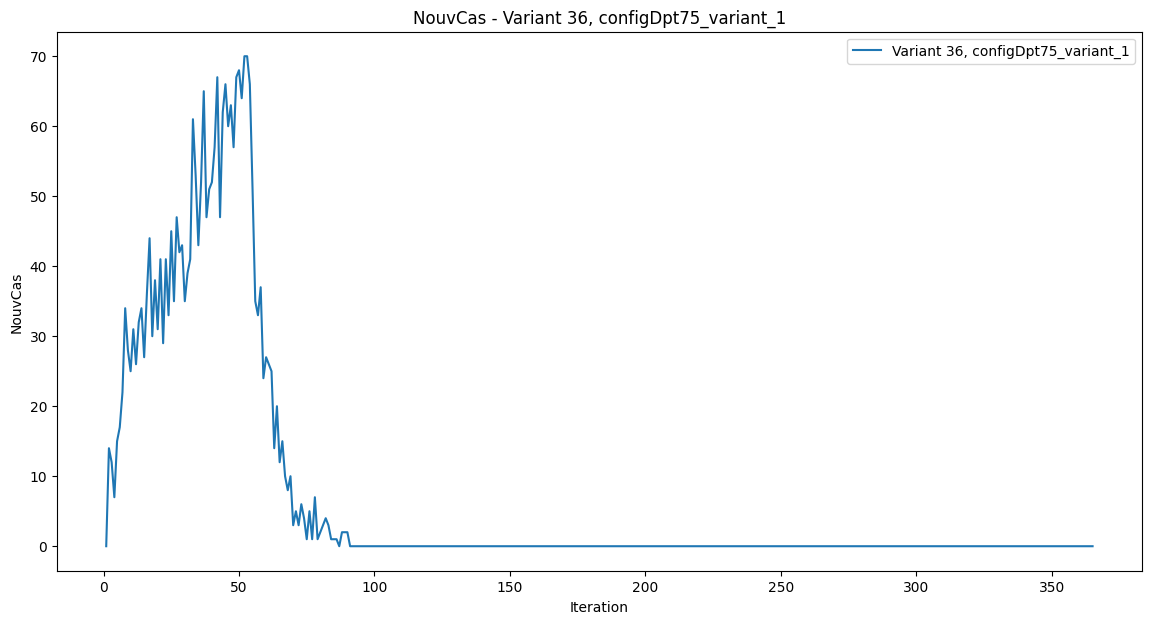

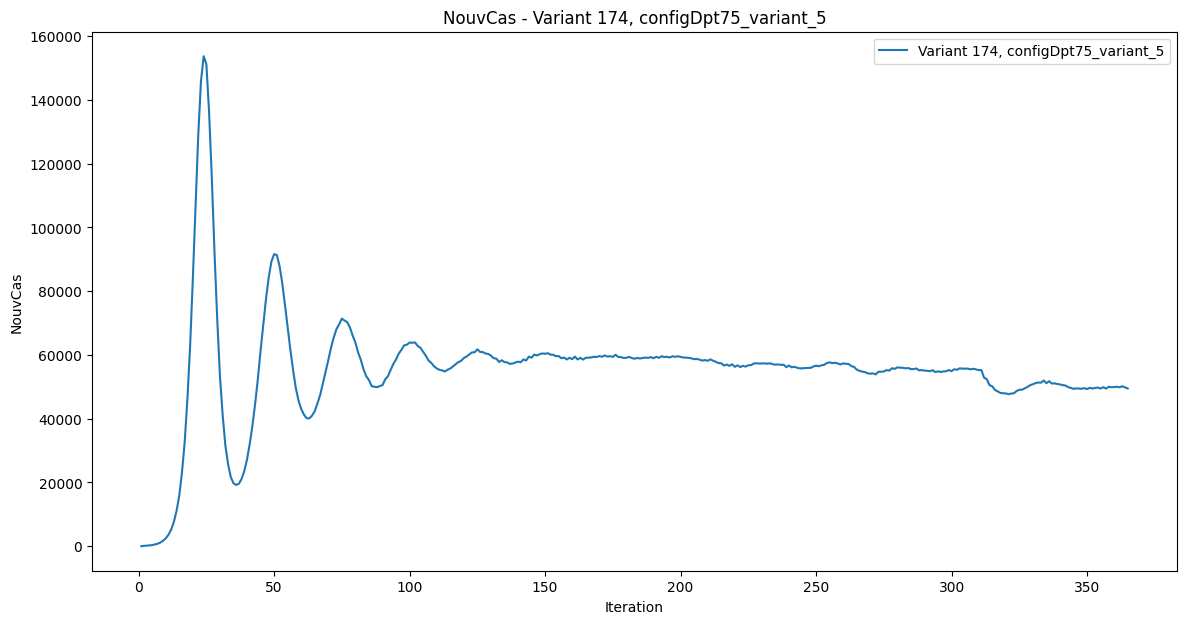

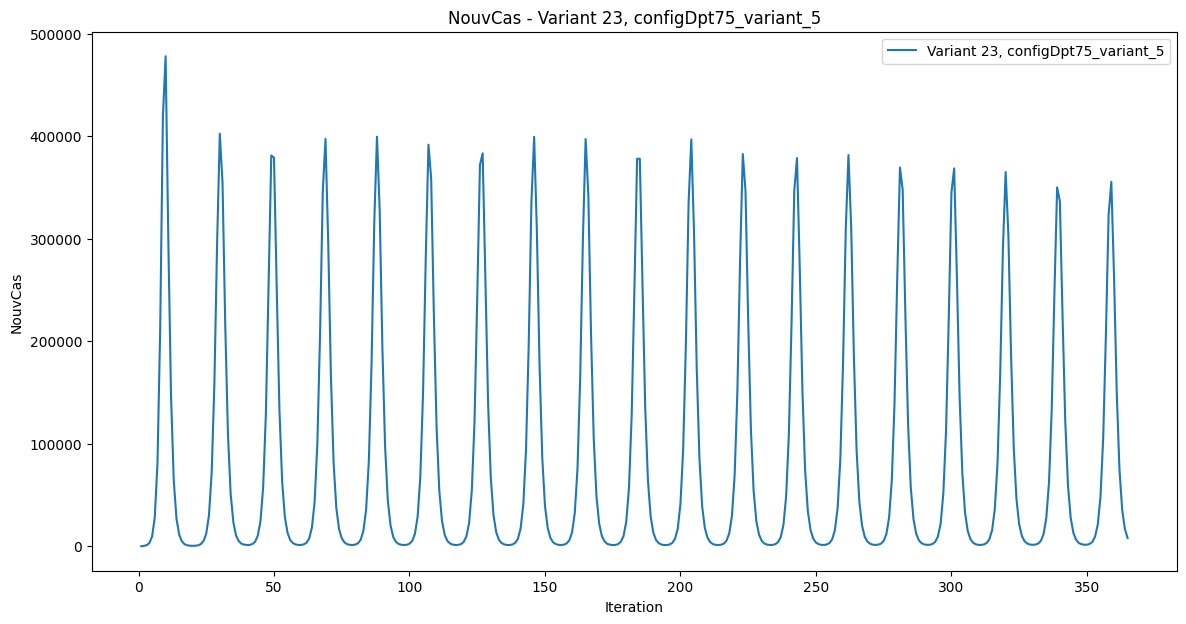

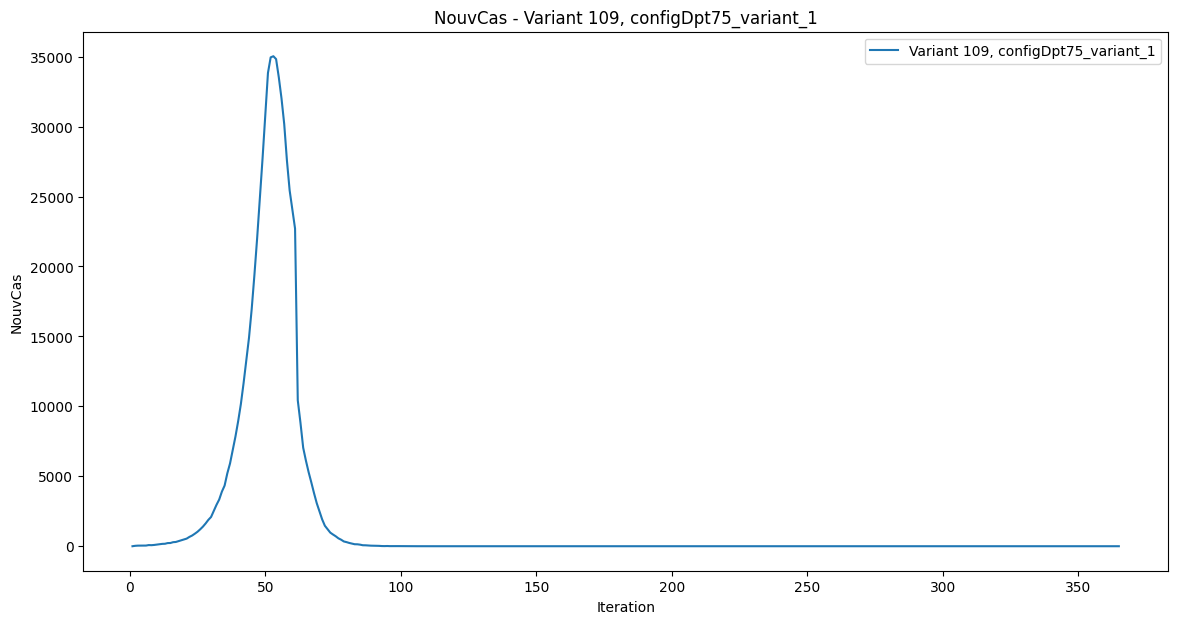

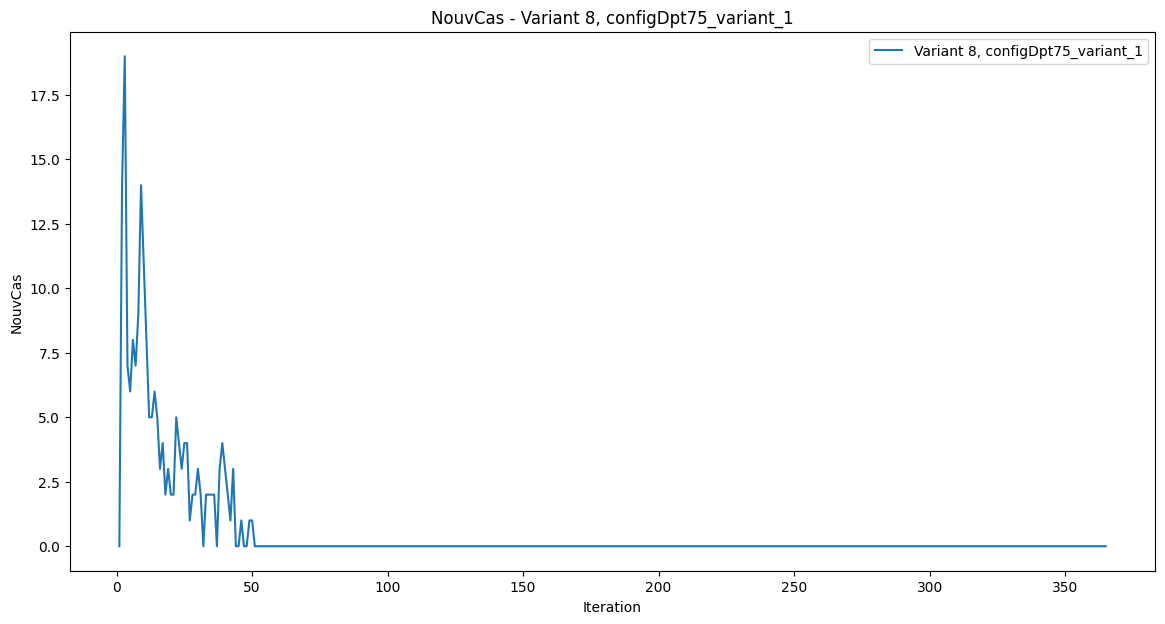

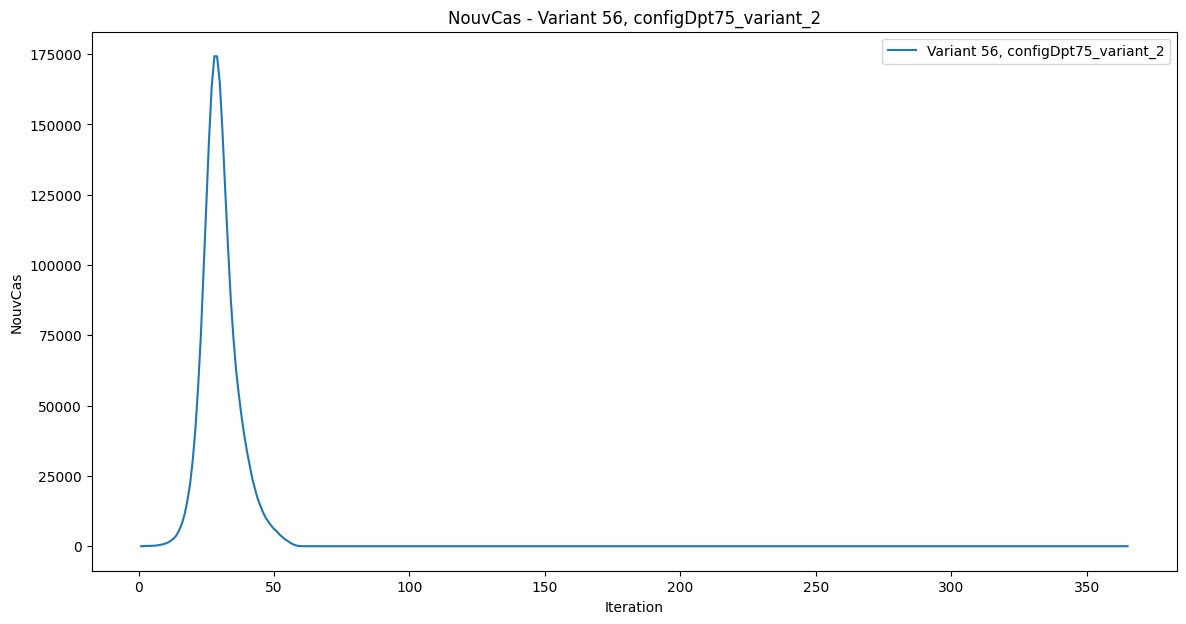

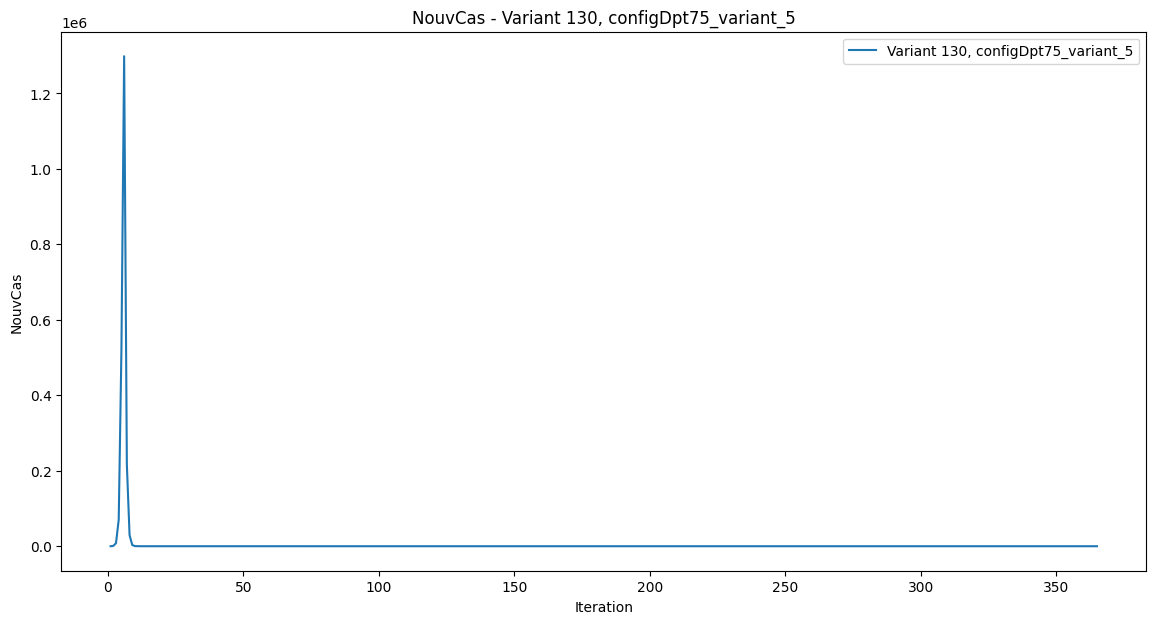

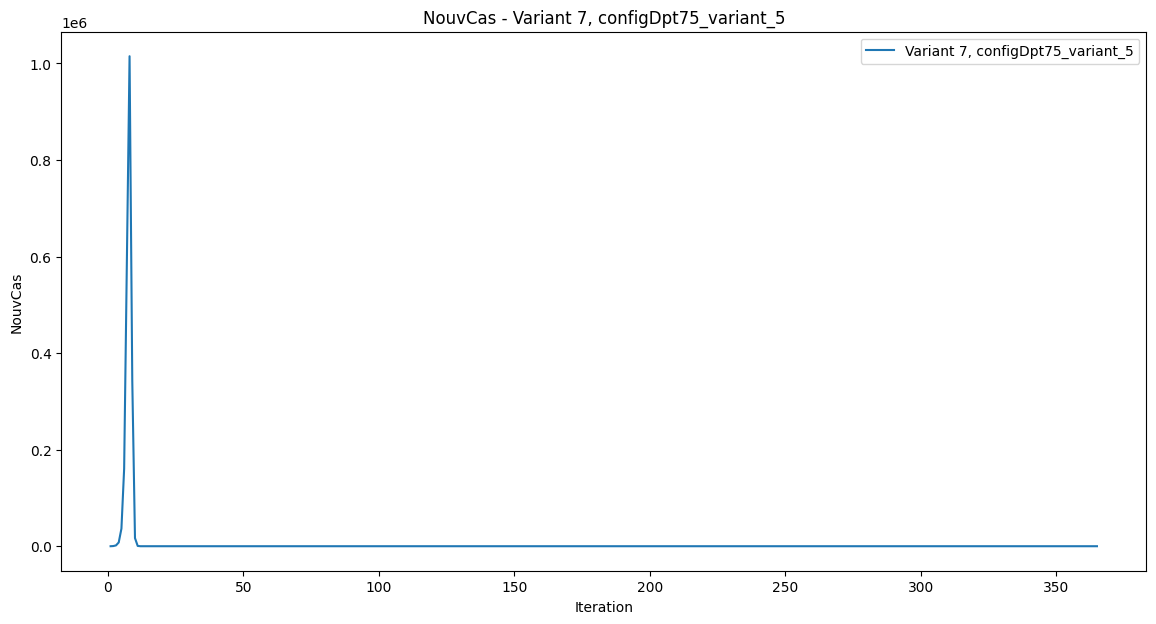

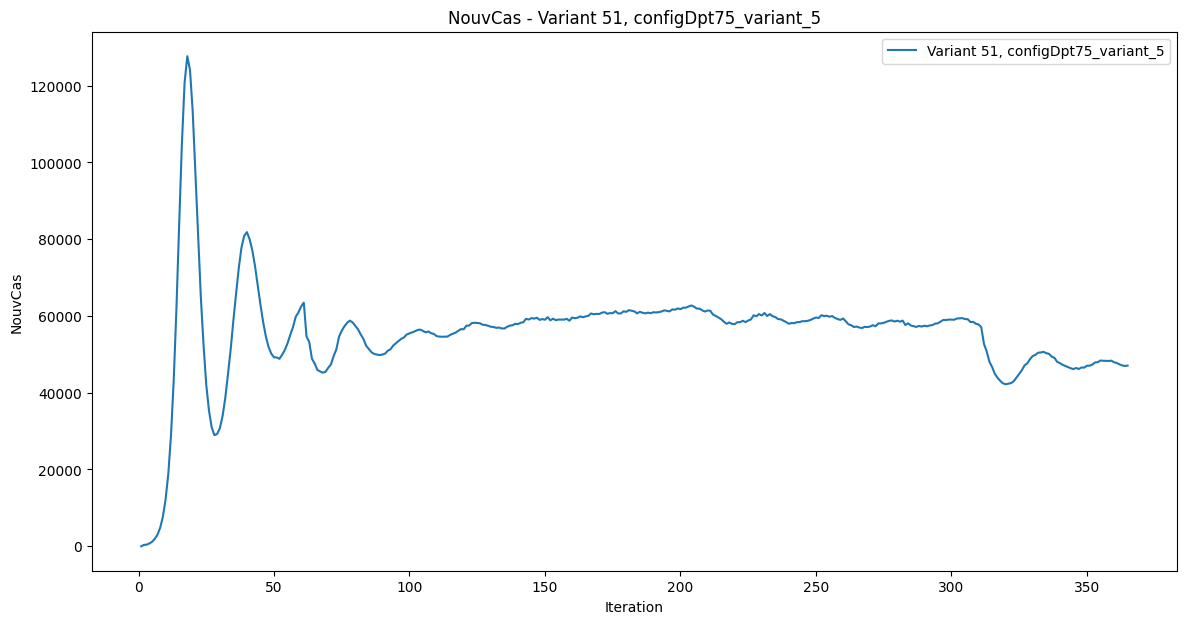

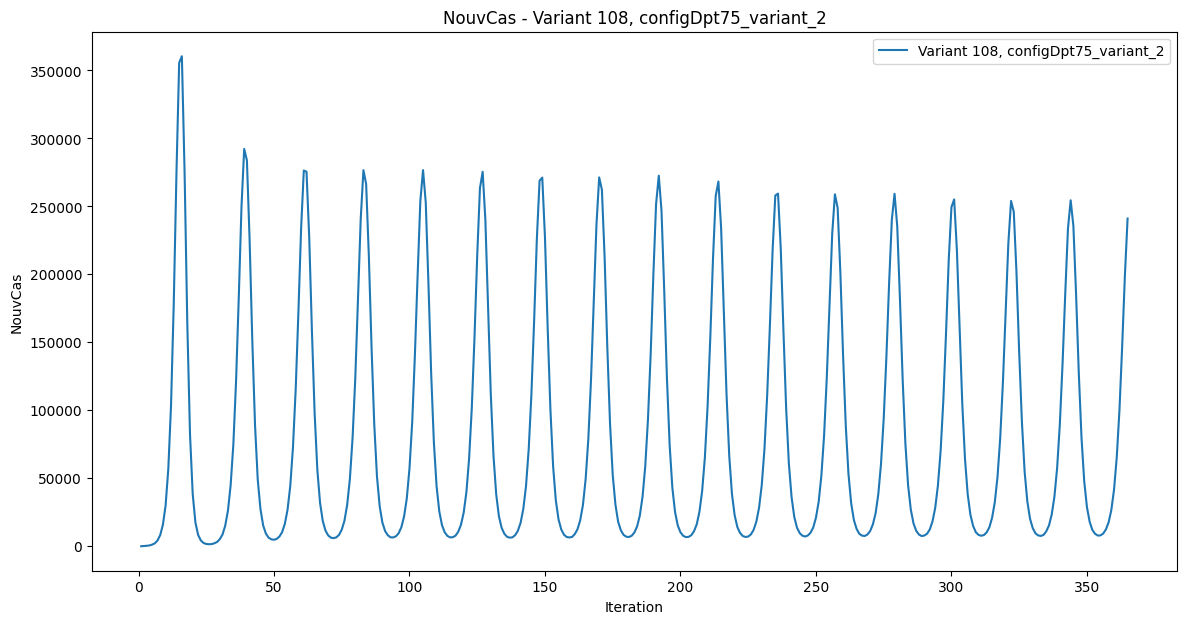

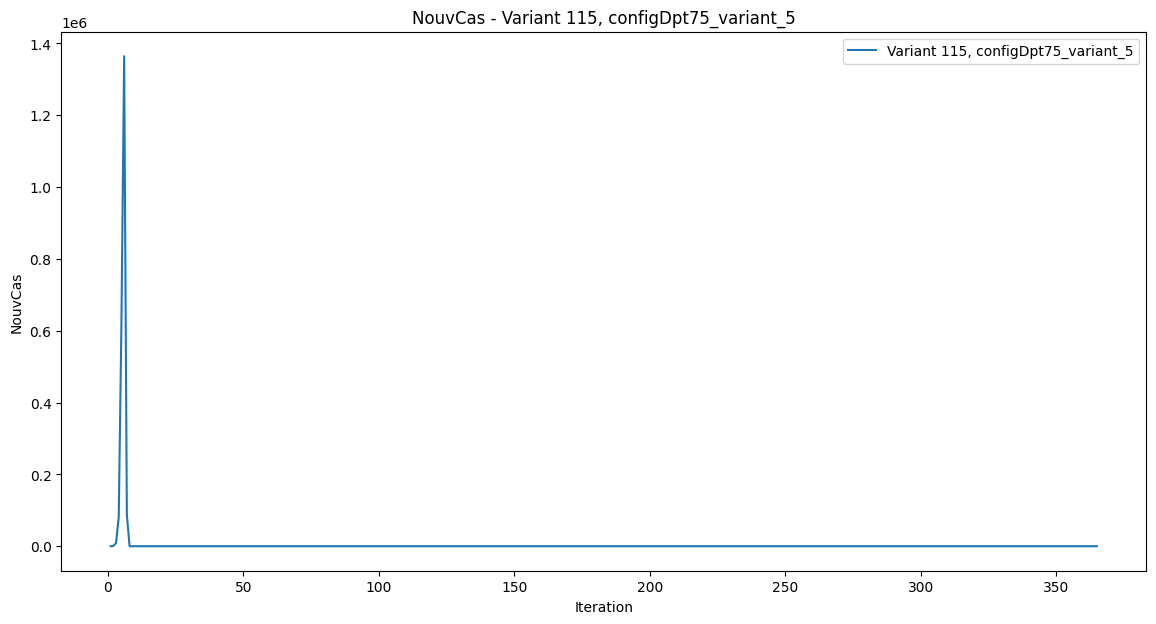

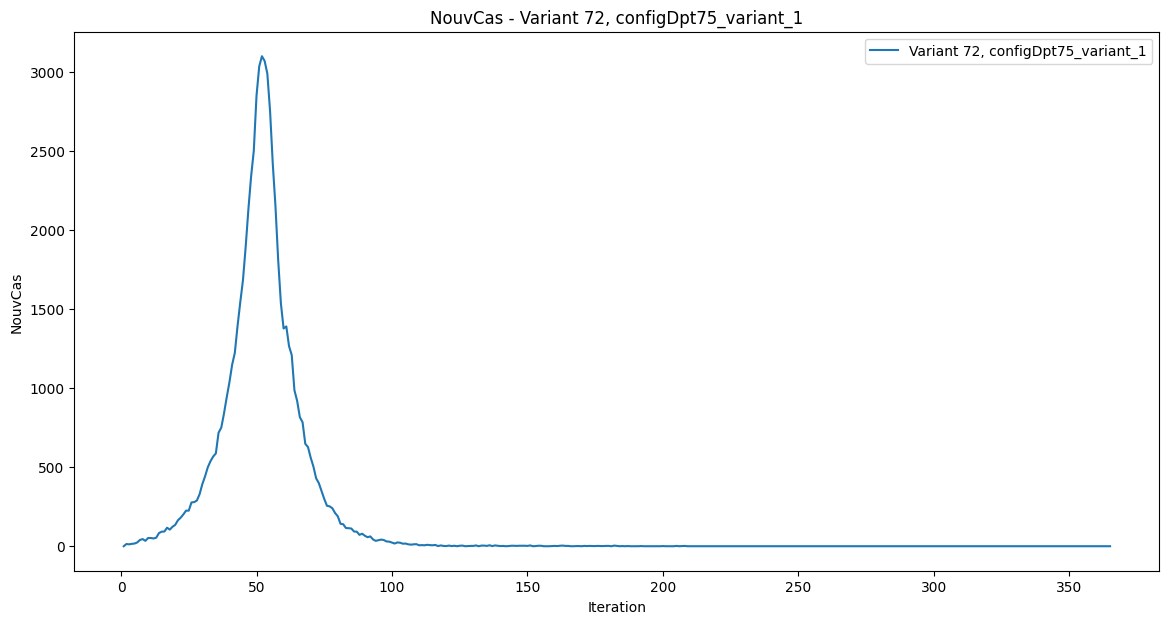

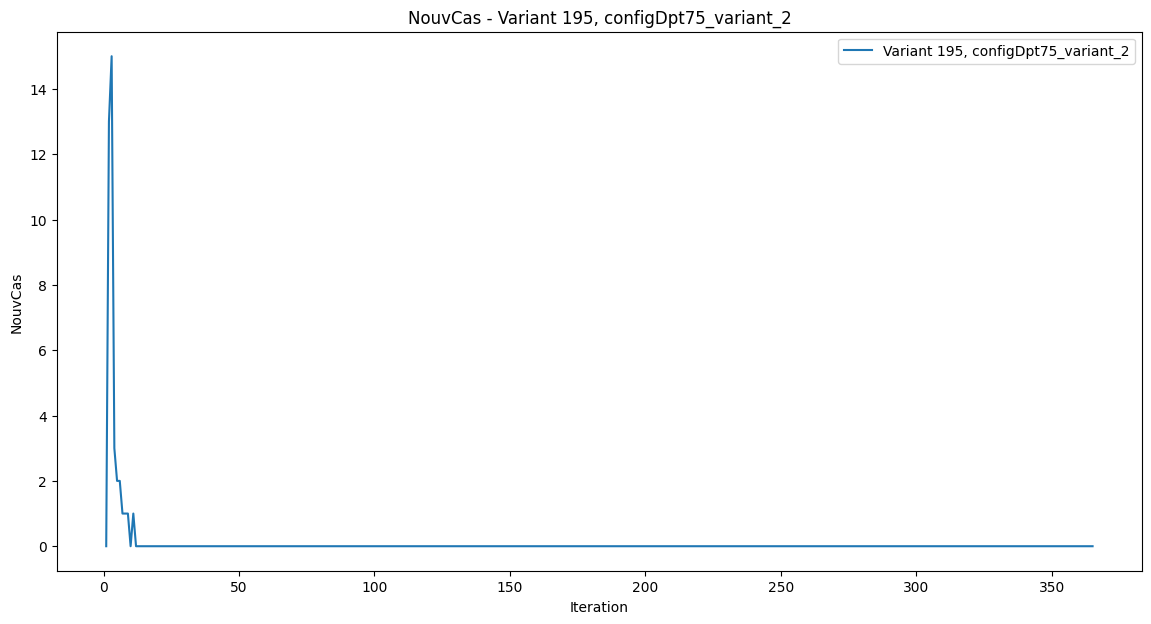

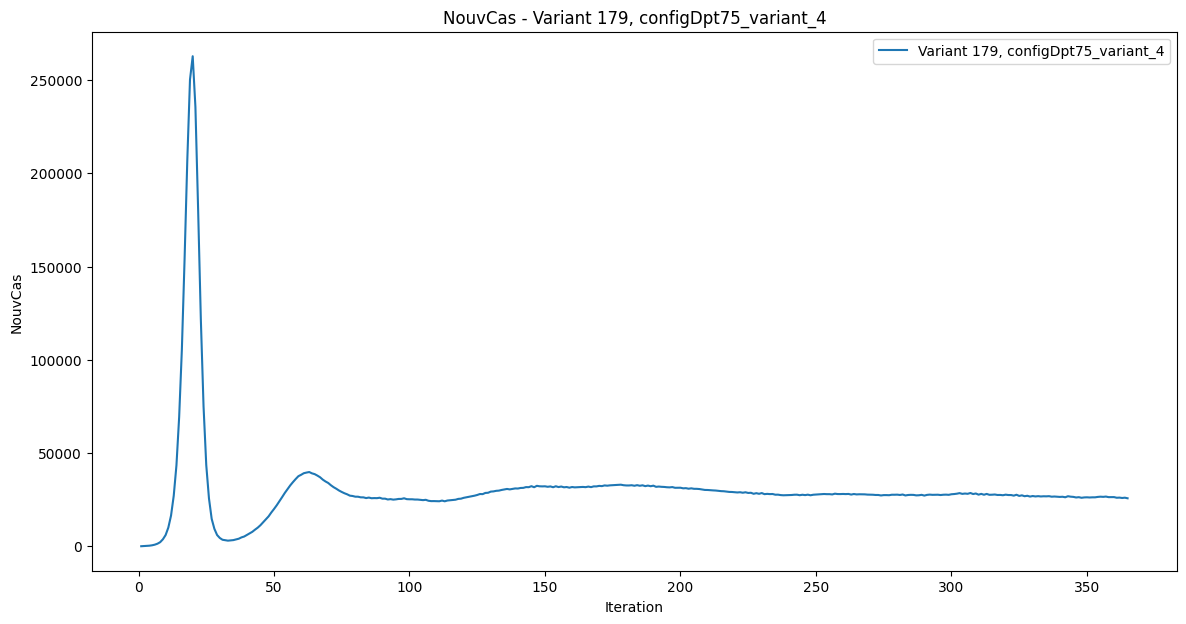

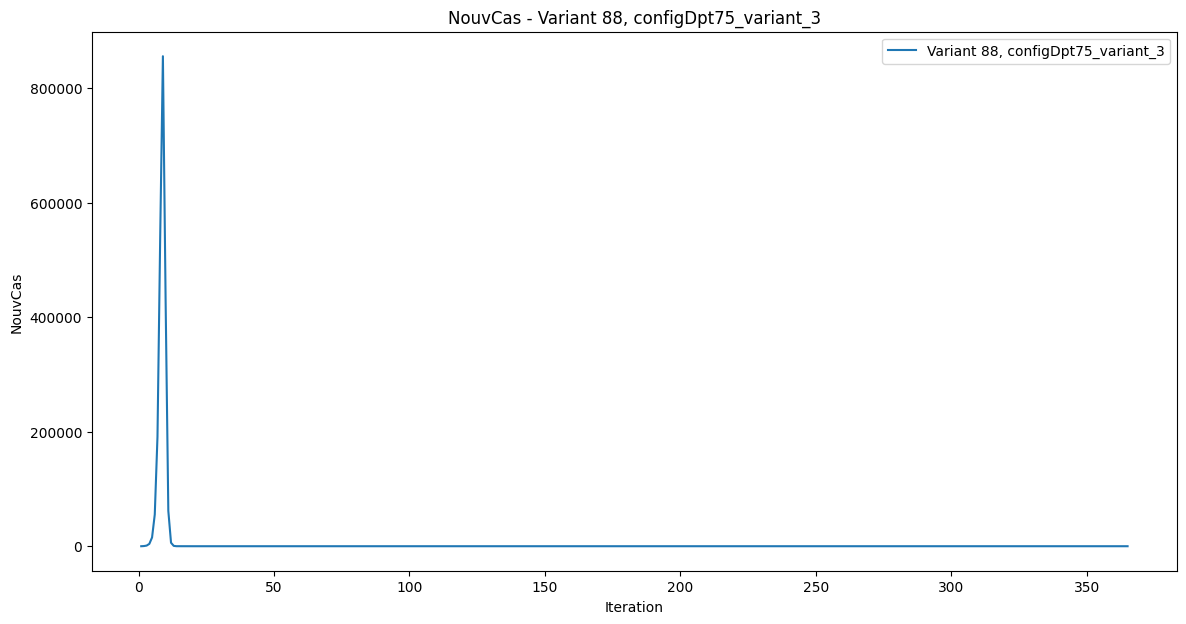

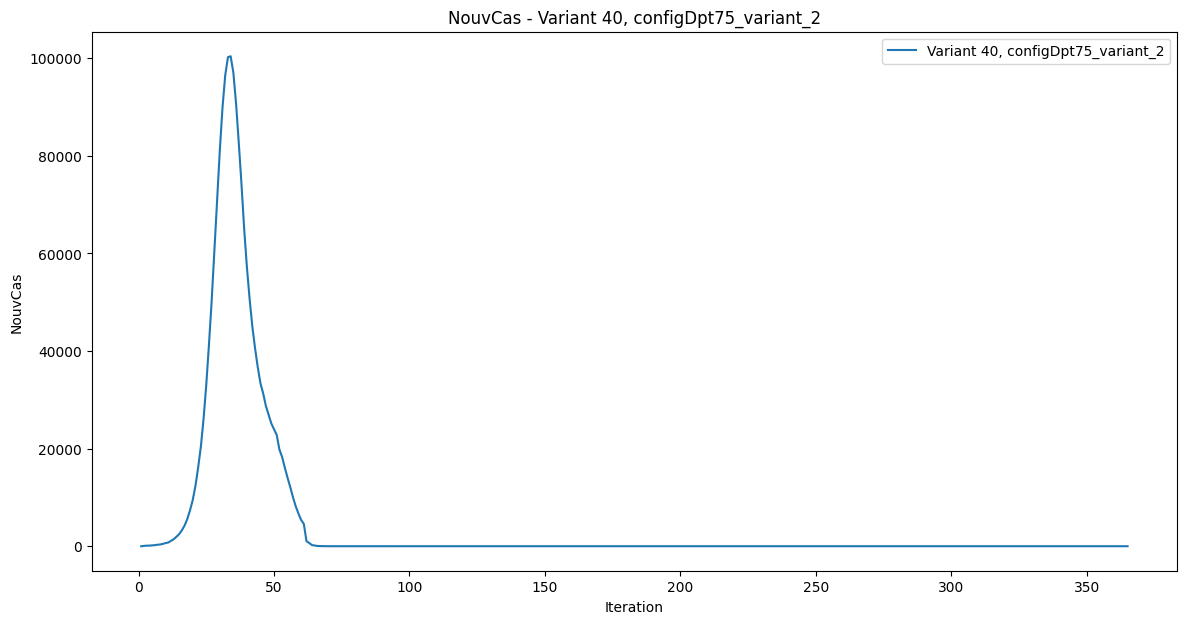

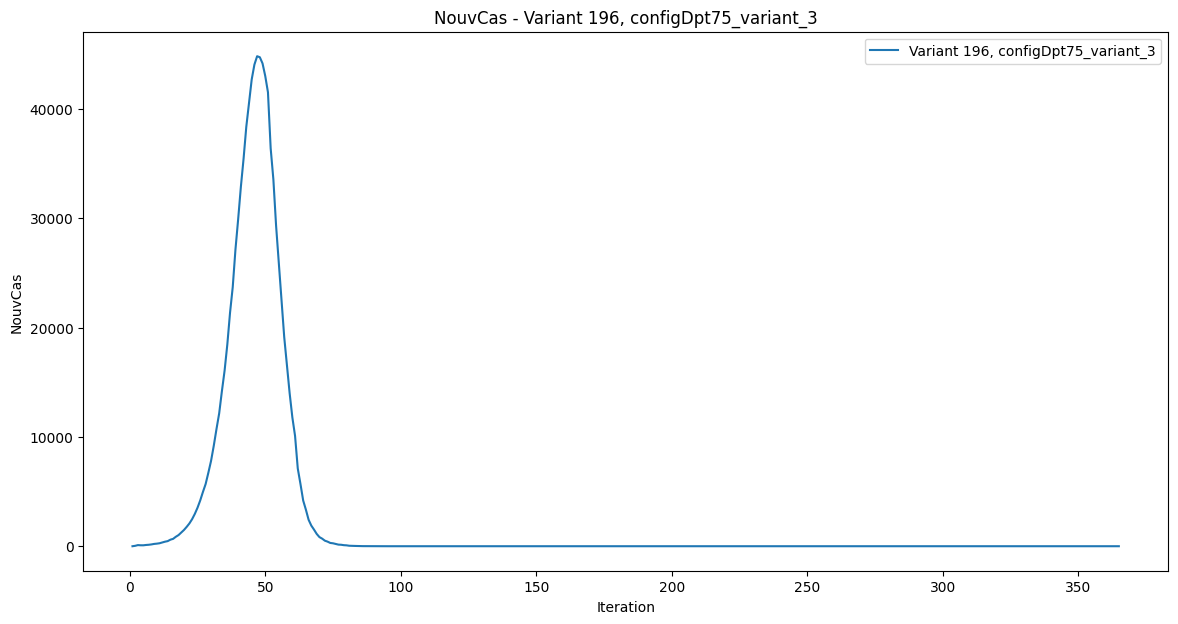

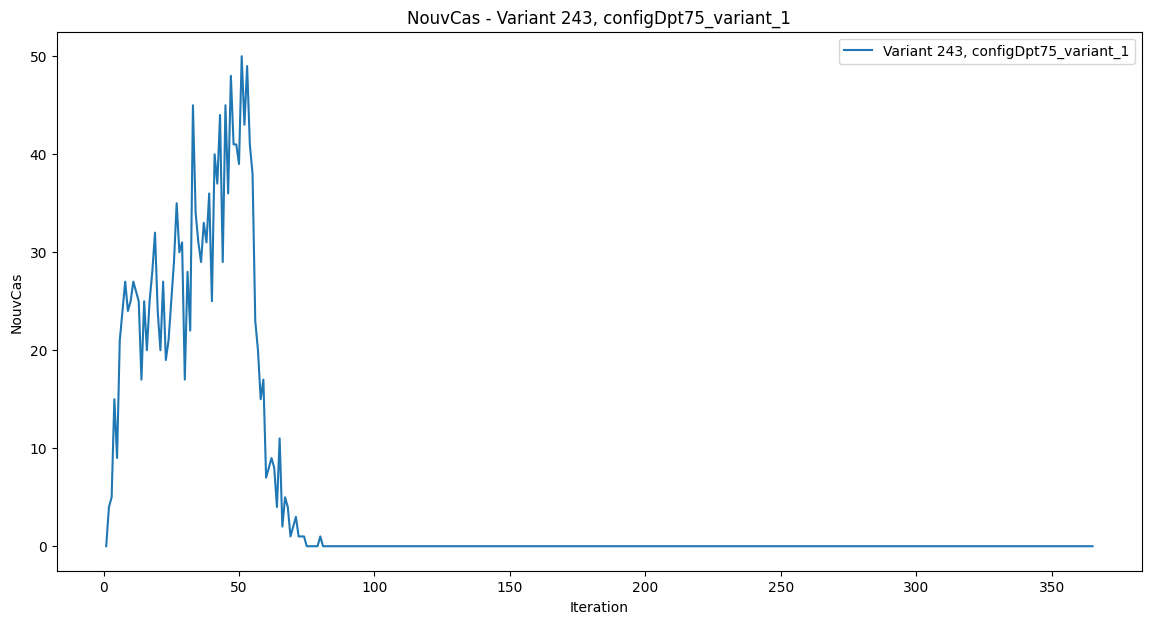

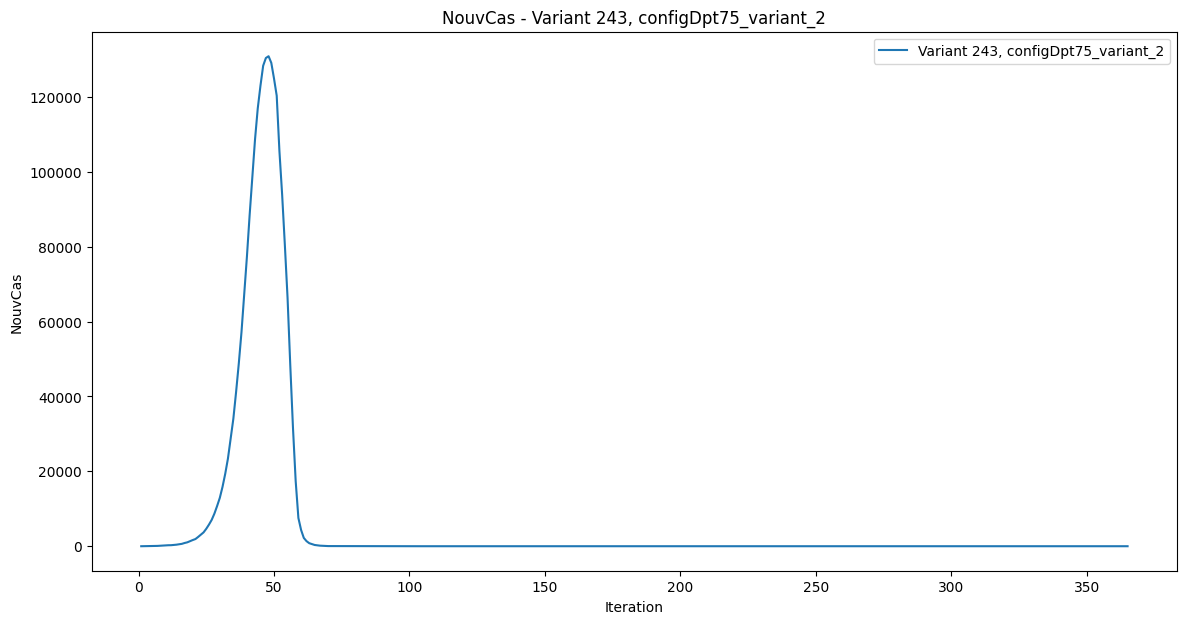

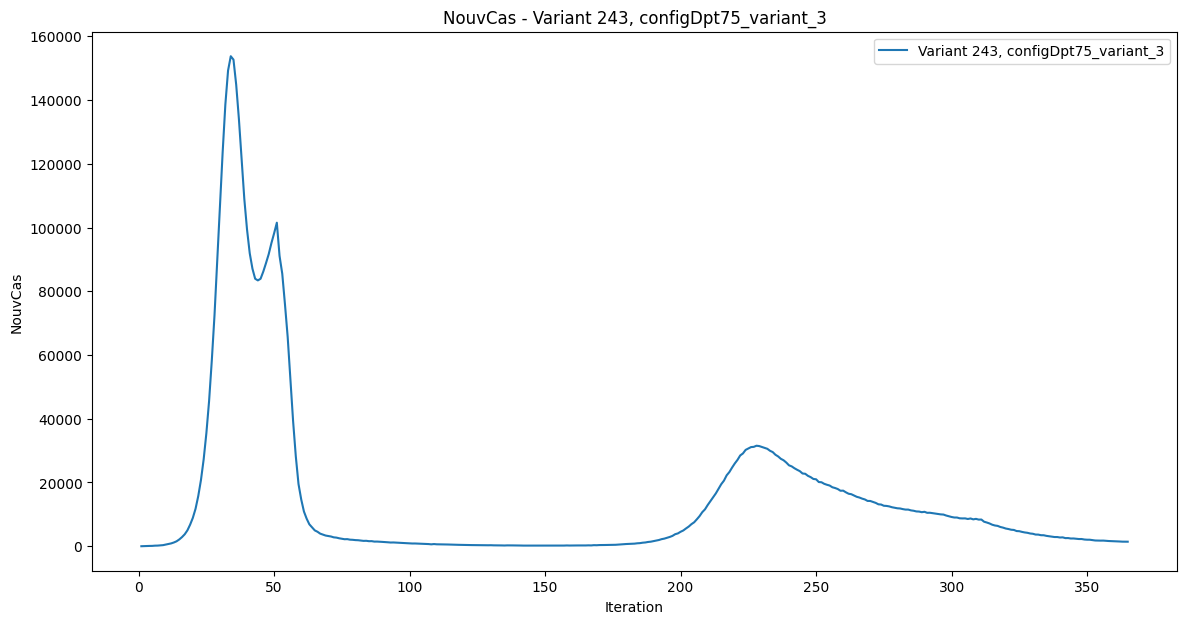

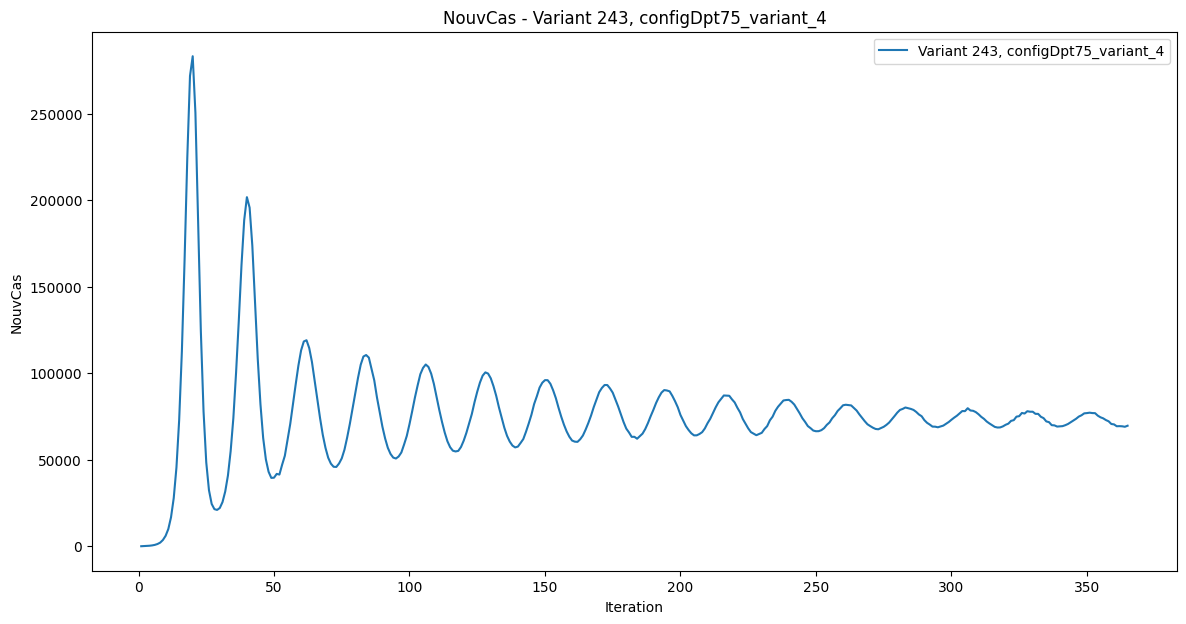

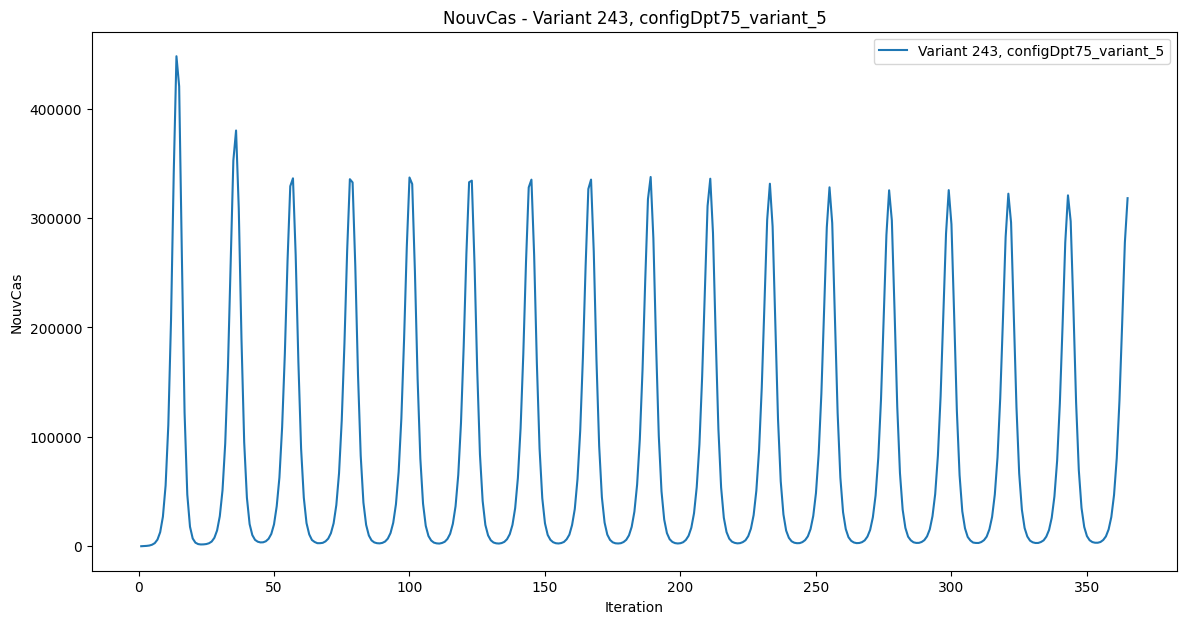

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Define constants
NB_REPLICATION = 3
NB_EXPERIMENTS = 20
NOM_EXPERIENCE = "configVaccin"
listDptConfig = ["configDpt75_variant_1", "configDpt75_variant_2", "configDpt75_variant_3", "configDpt75_variant_4", "configDpt75_variant_5"]
base_dirs = ["SMA-Covid-V2-ZZ3-MT-PlanExperience"]
folder = base_dirs[0]  
# Function to extract data from log files
def extract_experiment_results(folder, vaccin_variant, dpt_variant, repl_num):
    file_path = os.path.join(folder, f"log-{NOM_EXPERIENCE}_variant_{vaccin_variant}.txt-{dpt_variant}.txt-MT-mts000M00000{repl_num}NumRepli{repl_num}.txt")
    
    listNbNouvCas = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        for line in lines:
            if "CompteurRand:" in line:
                pass
            elif "NbHumainSimuDepart:" in line:
                pass
            elif "##" not in line:
                if i == 0:
                    i += 1
                elif i == 1:
                    listNbNouvCas.append(int(line))
                    i += 1
                elif i == 2:
                    i += 1
                elif i == 3:
                    i += 1
                elif i == 4:
                    i += 1
                elif i == 5:
                    i += 1
                elif i == 6:
                    i += 1
                elif i == 7:
                    i += 1
                elif i == 8:
                    i += 1
                elif i == 9:
                    i += 1
                elif "AgeC:" in line:
                    pass
                elif "AgeD:" in line:
                    pass
            else:
                i = 0
    
    return listNbNouvCas


RANDOM_SEED = 42
random.seed(RANDOM_SEED)
# Randomly select 10 experiments
random_experiments = [(random.randint(1, 244), random.randint(1, 5)) for _ in range(NB_EXPERIMENTS)]
listJour = [i for i in range(1,366)]
# Collect data for "NouvCas"
experiment_data = {}

for vaccin_variant, dpt_variant_num in random_experiments:
    dpt_variant = f"configDpt75_variant_{dpt_variant_num}"
    listNbNouvCas = extract_experiment_results(folder, vaccin_variant, dpt_variant, 0)
    plt.figure(figsize=(14, 7))
    plt.plot(listJour,listNbNouvCas, label=f"Variant {vaccin_variant}, {dpt_variant}")
    plt.title(f"NouvCas - Variant {vaccin_variant}, {dpt_variant}")
    plt.xlabel("Iteration")
    plt.ylabel("NouvCas")
    plt.legend()
    plt.show()

    
# Collect data specifically for configVariant729 and configDpt3/4/5
specific_experiments = [(243, 1),(243, 2),(243, 3), (243, 4), (243, 5)]

for vaccin_variant, dpt_variant_num in specific_experiments:
    dpt_variant = f"configDpt75_variant_{dpt_variant_num}"
    listNbNouvCas = extract_experiment_results(folder, vaccin_variant, dpt_variant, 0)
    plt.figure(figsize=(14, 7))
    plt.plot(listJour,listNbNouvCas, label=f"Variant {vaccin_variant}, {dpt_variant}")
    plt.title(f"NouvCas - Variant {vaccin_variant}, {dpt_variant}")
    plt.xlabel("Iteration")
    plt.ylabel("NouvCas")
    plt.legend()
    plt.show()


In [6]:
import pandas as pd
df_plan_experience = pd.read_csv("fullDfPlanExperience-Second.csv")
print(df_plan_experience)
print(df_plan_experience.columns)

      Unnamed: 0                                   ExperimentName  \
0              0    [0, 0, 0, 0, 0, 0]-variantVaccin1-variantDpt1   
1              1    [0, 0, 0, 0, 0, 1]-variantVaccin1-variantDpt2   
2              2    [0, 0, 0, 0, 0, 2]-variantVaccin1-variantDpt3   
3              3    [0, 0, 0, 0, 0, 3]-variantVaccin1-variantDpt4   
4              4    [0, 0, 0, 0, 0, 4]-variantVaccin1-variantDpt5   
...          ...                                              ...   
1210        1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1   
1211        1211  [2, 2, 2, 2, 2, 1]-variantVaccin243-variantDpt2   
1212        1212  [2, 2, 2, 2, 2, 2]-variantVaccin243-variantDpt3   
1213        1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4   
1214        1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5   

              Parameters  nbCasCovidConnuTotal-repli1  \
0     [0, 0, 0, 0, 0, 0]                        226.0   
1     [0, 0, 0, 0, 0, 1]                    1118046.0   


In [7]:

df_plan_experience = df_plan_experience.drop("nbCasCovidConnuTotal-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("nbCasCovidConnuTotal-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("nbCasCovidConnuTotal-repli3", axis=1)


df_plan_experience = df_plan_experience.drop("nbMortTotal-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("nbMortTotal-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("nbMortTotal-repli3", axis=1)


df_plan_experience = df_plan_experience.drop("epidemic_duration-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("epidemic_duration-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("epidemic_duration-repli3", axis=1)
df_plan_experience = df_plan_experience.drop("epidemic_duration-Mean", axis=1)
df_plan_experience = df_plan_experience.drop("epidemic_duration-Std", axis=1)

df_plan_experience = df_plan_experience.drop("tauxDeMortCasConnu-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("tauxDeMortCasConnu-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("tauxDeMortCasConnu-repli3", axis=1)


df_plan_experience = df_plan_experience.drop("tauxMortalitePopulationGlobale-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("tauxMortalitePopulationGlobale-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("tauxMortalitePopulationGlobale-repli3", axis=1)


df_plan_experience = df_plan_experience.drop("epidemicDuration-repli1", axis=1)
df_plan_experience = df_plan_experience.drop("epidemicDuration-repli2", axis=1)
df_plan_experience = df_plan_experience.drop("epidemicDuration-repli3", axis=1)


df_plan_experience = df_plan_experience.drop("Unnamed: 0", axis=1)

df_plan_experience = df_plan_experience.drop("nbCasCovidConnuTotal-Std", axis=1)
df_plan_experience = df_plan_experience.drop("nbMortTotal-Std", axis=1)
df_plan_experience = df_plan_experience.drop("tauxDeMortCasConnu-Std", axis=1)
df_plan_experience = df_plan_experience.drop("tauxMortalitePopulationGlobale-Std", axis=1)
df_plan_experience = df_plan_experience.drop("epidemicDuration-Std", axis=1)

print(df_plan_experience.columns)

Index(['ExperimentName', 'Parameters', 'nbCasCovidConnuTotal-Mean',
       'nbMortTotal-Mean', 'tauxDeMortCasConnu-Mean',
       'tauxMortalitePopulationGlobale-Mean', 'epidemicDuration-Mean'],
      dtype='object')


In [8]:
df_plan_experience

ExperimentName          Parameters  \
0       [0, 0, 0, 0, 0, 0]-variantVaccin1-variantDpt1  [0, 0, 0, 0, 0, 0]   
1       [0, 0, 0, 0, 0, 1]-variantVaccin1-variantDpt2  [0, 0, 0, 0, 0, 1]   
2       [0, 0, 0, 0, 0, 2]-variantVaccin1-variantDpt3  [0, 0, 0, 0, 0, 2]   
3       [0, 0, 0, 0, 0, 3]-variantVaccin1-variantDpt4  [0, 0, 0, 0, 0, 3]   
4       [0, 0, 0, 0, 0, 4]-variantVaccin1-variantDpt5  [0, 0, 0, 0, 0, 4]   
...                                               ...                 ...   
1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1  [2, 2, 2, 2, 2, 0]   
1211  [2, 2, 2, 2, 2, 1]-variantVaccin243-variantDpt2  [2, 2, 2, 2, 2, 1]   
1212  [2, 2, 2, 2, 2, 2]-variantVaccin243-variantDpt3  [2, 2, 2, 2, 2, 2]   
1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4  [2, 2, 2, 2, 2, 3]   
1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5  [2, 2, 2, 2, 2, 4]   

      nbCasCovidConnuTotal-Mean  nbMortTotal-Mean  tauxDeMortCasConnu-Mean  \
0                  2.503333e+02          3.000000                 1.260592   
1                  1.119471e+06      19235.000000                 1.718199   
2                  1.961362e+06      32469.333333                 1.655448   
3                  2.138077e+06      17554.333333                 0.821033   
4                  2.157462e+06      15840.333333                 0.734212   
...                         ...               ...                      ...   
1210               6.593333e+02          4.333333                 0.663239   
1211               1.781219e+06       9738.333333                 0.546724   
1212               5.306858e+06      28384.333333                 0.534866   
1213               2.746926e+07      83052.666667                 0.302348   
1214               3.169309e+07      89510.000000                 0.282428   

      tauxMortalitePopulationGlobale-Mean  epidemicDuration-Mean  
0                                0.000139              46.666667  
1                                0.888279              74.333333  
2                                1.499445              33.666667  
3                                0.810665              17.666667  
4                                0.731512              13.000000  
...                                   ...                    ...  
1210                             0.000200              74.000000  
1211                             0.449720              76.333333  
1212                             1.310799             364.000000  
1213                             3.835402             364.000000  
1214                             4.133603             364.000000  

[1215 rows x 7 columns]

In [9]:
# List of strings to search for
search_strings = [
    "variantVaccin243-variantDpt1",
    "variantVaccin26-variantDpt3",
    "variantVaccin105-variantDpt5",
    "variantVaccin160-variantDpt2",
    "variantVaccin78-variantDpt2",
    "variantVaccin243-variantDpt4",
    "variantVaccin243-variantDpt5"
]

# Filter the DataFrame
temp_df = df_plan_experience[df_plan_experience['ExperimentName'].str.contains('|'.join(search_strings))]

temp_df

ExperimentName          Parameters  \
127    [0, 0, 2, 2, 1, 2]-variantVaccin26-variantDpt3  [0, 0, 2, 2, 1, 2]   
386    [0, 2, 2, 1, 2, 1]-variantVaccin78-variantDpt2  [0, 2, 2, 1, 2, 1]   
524   [1, 0, 2, 1, 2, 4]-variantVaccin105-variantDpt5  [1, 0, 2, 1, 2, 4]   
796   [1, 2, 2, 2, 0, 1]-variantVaccin160-variantDpt2  [1, 2, 2, 2, 0, 1]   
1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1  [2, 2, 2, 2, 2, 0]   
1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4  [2, 2, 2, 2, 2, 3]   
1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5  [2, 2, 2, 2, 2, 4]   

      nbCasCovidConnuTotal-Mean  nbMortTotal-Mean  tauxDeMortCasConnu-Mean  \
127                2.894947e+07      94127.000000                 0.325143   
386                5.775667e+03         52.333333                 0.911672   
524                3.264235e+07      86498.333333                 0.264988   
796                3.161003e+07      99443.333333                 0.314595   
1210               6.593333e+02          4.333333                 0.663239   
1213               2.746926e+07      83052.666667                 0.302348   
1214               3.169309e+07      89510.000000                 0.282428   

      tauxMortalitePopulationGlobale-Mean  epidemicDuration-Mean  
127                              4.346818             364.000000  
386                              0.002417              64.333333  
524                              3.994524             364.000000  
796                              4.592328             364.000000  
1210                             0.000200              74.000000  
1213                             3.835402             364.000000  
1214                             4.133603             364.000000

In [4]:
"""
https://fr.wikipedia.org/wiki/Analyse_de_sensibilit%C3%A9

Il y a différentes méthodes pour l'analyse de sensibilité

Méthode 1 : L'analyse par régression
L'analyse par régression, dans le contexte de l'analyse de sensibilité, 
consiste à utiliser les coefficients de régression standardisés comme des mesures directes de la sensibilité. 
La régression doit être linéaire par rapport aux données. 
Sinon il est difficile d'interpréter les coefficients standardisés. 
Cette méthode est donc plus appropriée lorsque le modèle de réponse est en fait linéaire ; 
la linéarité peut être confirmée, par exemple, si le coefficient de détermination est grand. 
Les avantages de l'analyse par régression sont qu'elle est simple et a un faible coût de calcul.

On constate que R2 n'est pas proche de 1, 
on en déduis que la relation entre les variables d'entrée et les sorties ne sont pas vraiment linéaires.




"""

"\nhttps://fr.wikipedia.org/wiki/Analyse_de_sensibilit%C3%A9\n\nIl y a différentes méthodes pour l'analyse de sensibilité\n\nMéthode 1 : L'analyse par régression\nL'analyse par régression, dans le contexte de l'analyse de sensibilité, \nconsiste à utiliser les coefficients de régression standardisés comme des mesures directes de la sensibilité. \nLa régression doit être linéaire par rapport aux données. \nSinon il est difficile d'interpréter les coefficients standardisés. \nCette méthode est donc plus appropriée lorsque le modèle de réponse est en fait linéaire ; \nla linéarité peut être confirmée, par exemple, si le coefficient de détermination est grand. \nLes avantages de l'analyse par régression sont qu'elle est simple et a un faible coût de calcul.\n\nOn constate que R2 n'est pas proche de 1, \non en déduis que la relation entre les variables d'entrée et les sorties ne sont pas vraiment linéaires.\n\n\n\n\n"

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = df_plan_experience
"""
The index of the list correspond to the parameters:
index 0 = histogram_contamination_variants
index 1 = asymptomatic
index 2 = resistance_reinfection
index 3 = max_resistance_vaccin and min_resistance_vaccin
index 4 = timelineVaccination
index 5 = nb_deplacement_jour
"""

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score



# Extraire les paramètres d'entrée
# Assumons que 'Parameters' est une colonne contenant des listes de longueur fixe
parameters_df = pd.DataFrame(df['Parameters'].apply(eval).tolist(), columns=[f'Param{i+1}' for i in range(6)])
df = pd.concat([df, parameters_df], axis=1)

# Variables de sortie
dependent_vars = ['nbCasCovidConnuTotal-Mean', 'nbMortTotal-Mean', 'tauxDeMortCasConnu-Mean', 
                  'tauxMortalitePopulationGlobale-Mean', 'epidemicDuration-Mean']

# Variables d'entrée
independent_vars = [f'Param{i+1}' for i in range(6)]

# Dictionnaire pour stocker les résultats
results = {}

X = df[independent_vars].values
print("X value :" + str(X))
print("len x: " + str(len(X)))
# Effectuer la régression linéaire et évaluer la linéarité pour chaque variable de sortie
for dep_var in dependent_vars:
    
    y = df[dep_var].values
    print("Y value :" + str(y))
    print("len Y: " + str(len(y)))
    # Création et ajustement du modèle
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédictions
    y_pred = model.predict(X)
    
    # Calcul du coefficient de détermination (R²)
    r2 = r2_score(y, y_pred)
    
    # Stocker les résultats
    results[dep_var] = {'R2': r2, 'Coefficients': model.coef_}

# Afficher les résultats
for dep_var, result in results.items():
    print(f"Variable dépendante : {dep_var}")
    print(f"  Coefficient de détermination (R²) : {result['R2']:.4f}")
    print(f"  Coefficients de régression : {result['Coefficients']}")
    print("\n")


X value :[[0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 2]
 ...
 [2 2 2 2 2 2]
 [2 2 2 2 2 3]
 [2 2 2 2 2 4]]
len x: 1215
Y value :[2.50333333e+02 1.11947133e+06 1.96136167e+06 ... 5.30685767e+06
 2.74692567e+07 3.16930910e+07]
len Y: 1215
Y value :[3.00000000e+00 1.92350000e+04 3.24693333e+04 ... 2.83843333e+04
 8.30526667e+04 8.95100000e+04]
len Y: 1215
Y value :[1.26059174 1.71819929 1.65544819 ... 0.53486571 0.30234792 0.28242825]
len Y: 1215
Y value :[1.38541061e-04 8.88279103e-01 1.49944530e+00 ... 1.31079855e+00
 3.83540152e+00 4.13360346e+00]
len Y: 1215
Y value :[ 46.66666667  74.33333333  33.66666667 ... 364.         364.
 364.        ]
len Y: 1215
Variable dépendante : nbCasCovidConnuTotal-Mean
  Coefficient de détermination (R²) : 0.3388
  Coefficients de régression : [-1782376.66049383  1442275.45473251  5245650.02304527  -153416.85102881
   271102.1218107   2993025.99368999]


Variable dépendante : nbMortTotal-Mean
  Coefficient de détermination (R²) : 0.3661
  Coefficients de

In [12]:
df.columns

Index(['ExperimentName', 'Parameters', 'nbCasCovidConnuTotal-Mean',
       'nbMortTotal-Mean', 'tauxDeMortCasConnu-Mean',
       'tauxMortalitePopulationGlobale-Mean', 'epidemicDuration-Mean',
       'Param1', 'Param2', 'Param3', 'Param4', 'Param5', 'Param6'],
      dtype='object')

In [13]:
df

ExperimentName          Parameters  \
0       [0, 0, 0, 0, 0, 0]-variantVaccin1-variantDpt1  [0, 0, 0, 0, 0, 0]   
1       [0, 0, 0, 0, 0, 1]-variantVaccin1-variantDpt2  [0, 0, 0, 0, 0, 1]   
2       [0, 0, 0, 0, 0, 2]-variantVaccin1-variantDpt3  [0, 0, 0, 0, 0, 2]   
3       [0, 0, 0, 0, 0, 3]-variantVaccin1-variantDpt4  [0, 0, 0, 0, 0, 3]   
4       [0, 0, 0, 0, 0, 4]-variantVaccin1-variantDpt5  [0, 0, 0, 0, 0, 4]   
...                                               ...                 ...   
1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1  [2, 2, 2, 2, 2, 0]   
1211  [2, 2, 2, 2, 2, 1]-variantVaccin243-variantDpt2  [2, 2, 2, 2, 2, 1]   
1212  [2, 2, 2, 2, 2, 2]-variantVaccin243-variantDpt3  [2, 2, 2, 2, 2, 2]   
1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4  [2, 2, 2, 2, 2, 3]   
1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5  [2, 2, 2, 2, 2, 4]   

      nbCasCovidConnuTotal-Mean  nbMortTotal-Mean  tauxDeMortCasConnu-Mean  \
0                  2.503333e+02          3.000000                 1.260592   
1                  1.119471e+06      19235.000000                 1.718199   
2                  1.961362e+06      32469.333333                 1.655448   
3                  2.138077e+06      17554.333333                 0.821033   
4                  2.157462e+06      15840.333333                 0.734212   
...                         ...               ...                      ...   
1210               6.593333e+02          4.333333                 0.663239   
1211               1.781219e+06       9738.333333                 0.546724   
1212               5.306858e+06      28384.333333                 0.534866   
1213               2.746926e+07      83052.666667                 0.302348   
1214               3.169309e+07      89510.000000                 0.282428   

      tauxMortalitePopulationGlobale-Mean  epidemicDuration-Mean  Param1  \
0                                0.000139              46.666667       0   
1                                0.888279              74.333333       0   
2                                1.499445              33.666667       0   
3                                0.810665              17.666667       0   
4                                0.731512              13.000000       0   
...                                   ...                    ...     ...   
1210                             0.000200              74.000000       2   
1211                             0.449720              76.333333       2   
1212                             1.310799             364.000000       2   
1213                             3.835402             364.000000       2   
1214                             4.133603             364.000000       2   

      Param2  Param3  Param4  Param5  Param6  
0          0       0       0       0       0  
1          0       0       0       0       1  
2          0       0       0       0       2  
3          0       0       0       0       3  
4          0       0       0       0       4  
...      ...     ...     ...     ...     ...  
1210       2       2       2       2       0  
1211       2       2       2       2       1  
1212       2       2       2       2       2  
1213       2       2       2       2       3  
1214       2       2       2       2       4  

[1215 rows x 13 columns]

Dependent Variable: TotalKnownCovidCases-Mean
  Coefficient of Determination (R²): 0.8973
  Importance of Variables: [0.15650006 0.04720689 0.24134146 0.14023584 0.06511735 0.34959839]


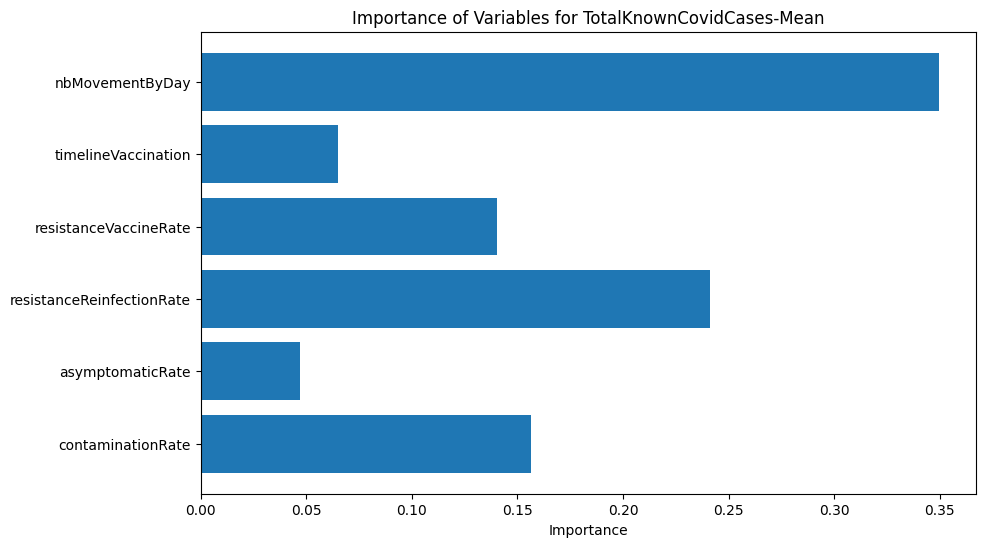

Dependent Variable: TotalDeaths-Mean
  Coefficient of Determination (R²): 0.8804
  Importance of Variables: [0.16076044 0.05101595 0.21752575 0.12095678 0.0897129  0.36002819]


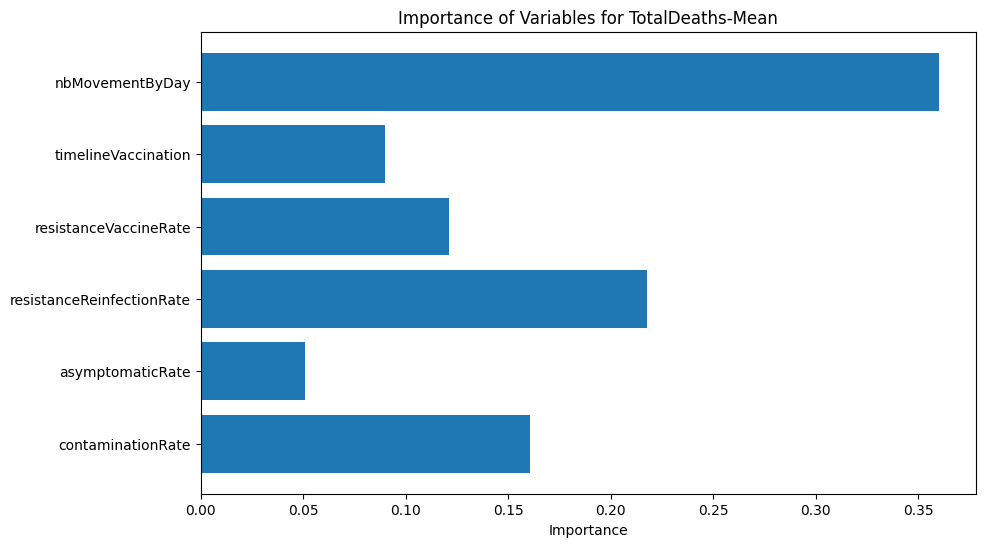

Dependent Variable: KnownCaseMortalityRate-Mean
  Coefficient of Determination (R²): 0.8617
  Importance of Variables: [0.18582191 0.07672211 0.12942307 0.13898553 0.18147255 0.28757482]


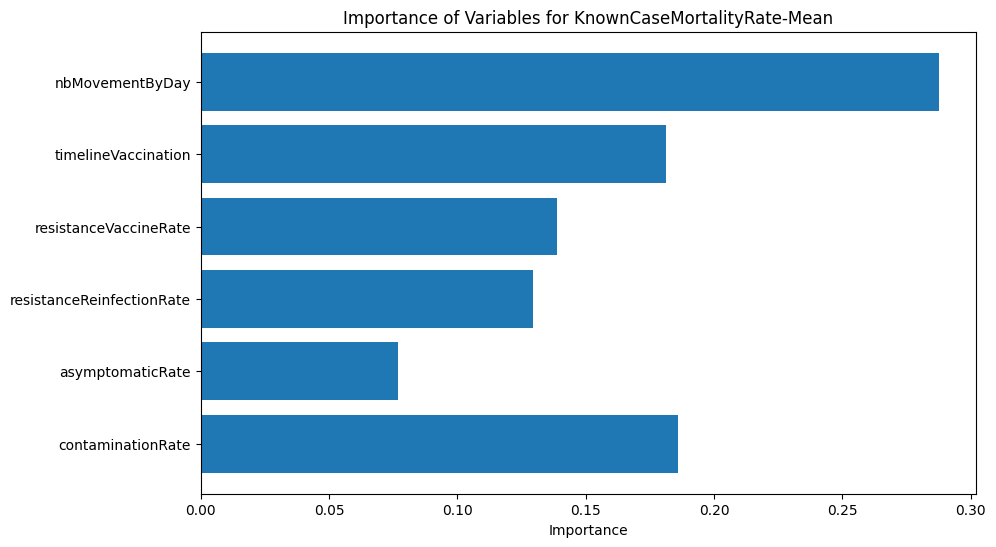

Dependent Variable: OverallPopulationMortalityRate-Mean
  Coefficient of Determination (R²): 0.8817
  Importance of Variables: [0.16046098 0.05114674 0.2173095  0.12098031 0.08995817 0.3601443 ]


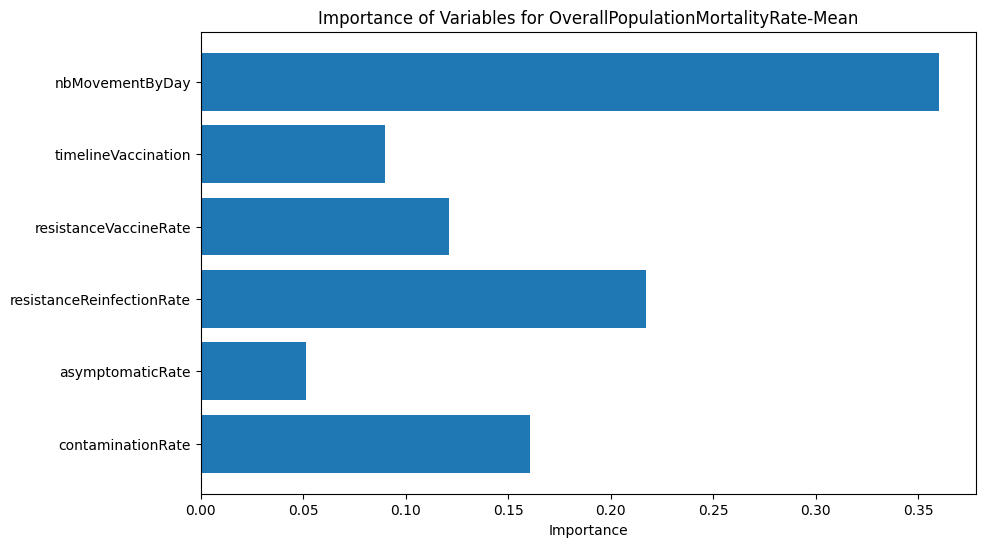

Dependent Variable: EpidemicDuration-Mean
  Coefficient of Determination (R²): 0.8212
  Importance of Variables: [0.17982375 0.06122999 0.18807218 0.18871358 0.09076123 0.29139926]


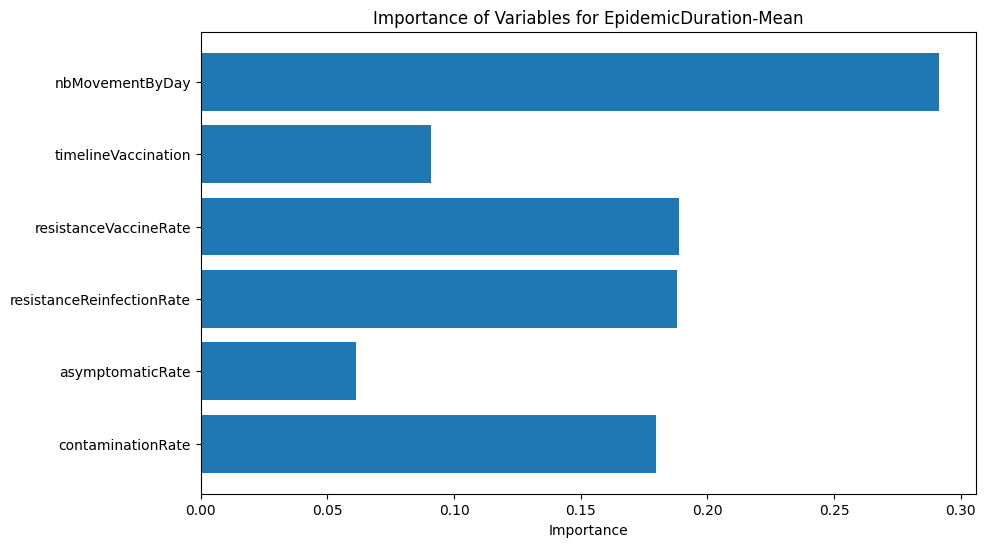

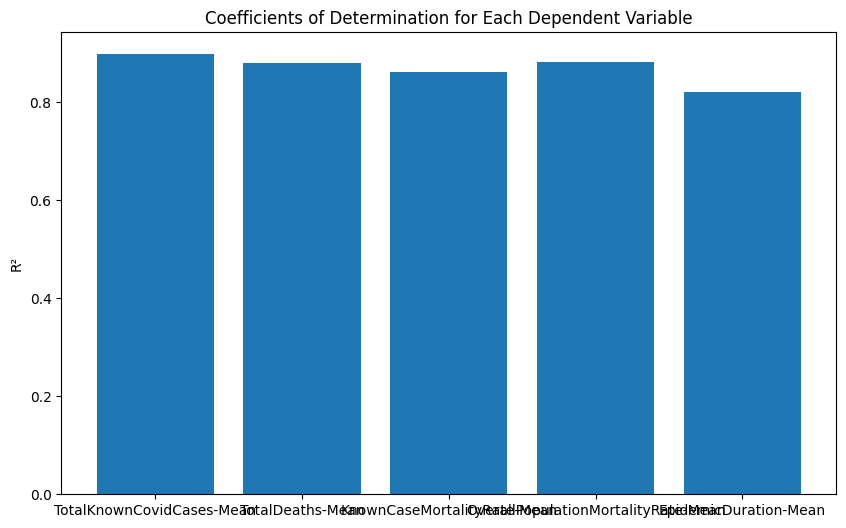

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



# Descriptive names for independent variables
descriptive_names = [
    'contaminationRate',
    'asymptomaticRate',
    'resistanceReinfectionRate',
    'resistanceVaccineRate',
    'timelineVaccination',
    'nbMovementByDay'
]

# Translated names for dependent variables
translated_dependent_vars = [
    'TotalKnownCovidCases-Mean',
    'TotalDeaths-Mean',
    'KnownCaseMortalityRate-Mean',
    'OverallPopulationMortalityRate-Mean',
    'EpidemicDuration-Mean'
]

# Dictionary to store the results
results = {}

# Perform random forest regression and evaluate for each dependent variable
for dep_var in dependent_vars:
    X = df[independent_vars].values
    y = df[dep_var].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and fit the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate the coefficient of determination (R²)
    r2 = r2_score(y_test, y_pred)
    
    # Importance of variables
    importances = model.feature_importances_
    
    # Store the results
    results[dep_var] = {'R2': r2, 'Importances': importances}

# Display the results and plot the figures
for dep_var, translated_dep_var in zip(dependent_vars, translated_dependent_vars):
    result = results[dep_var]
    print(f"Dependent Variable: {translated_dep_var}")
    print(f"  Coefficient of Determination (R²): {result['R2']:.4f}")
    print(f"  Importance of Variables: {result['Importances']}")
    
    # Plot the variable importances
    plt.figure(figsize=(10, 6))
    plt.barh(descriptive_names, result['Importances'], align='center')
    plt.xlabel('Importance')
    plt.title(f'Importance of Variables for {translated_dep_var}')
    plt.show()

# Plot the coefficients of determination
r2_scores = [result['R2'] for result in results.values()]
plt.figure(figsize=(10, 6))
plt.bar(translated_dependent_vars, r2_scores, align='center')
plt.ylabel('R²')
plt.title('Coefficients of Determination for Each Dependent Variable')
plt.show()

In [9]:
"""
https://salib.readthedocs.io/en/latest/

SALib - Sensitivity Analysis Library in Python

Python implementations of commonly used sensitivity analysis methods, including Sobol, Morris, and FAST methods. Useful in systems modeling to calculate the effects of model inputs or exogenous factors on outputs of interest.
Supported Methods

    Sobol Sensitivity Analysis (Sobol 2001, Saltelli 2002, Saltelli et al. 2010)

    Method of Morris, including groups and optimal trajectories (Morris 1991, Campolongo et al. 2007)

    Fourier Amplitude Sensitivity Test (FAST) (Cukier et al. 1973, Saltelli et al. 1999)

    Random Balance Designs - Fourier Amplitude Sensitivity Test (RBD-FAST) (Tarantola et al. 2006, Elmar Plischke 2010, Tissot et al. 2012)

    Delta Moment-Independent Measure (Borgonovo 2007, Plischke et al. 2013)

    Derivative-based Global Sensitivity Measure (DGSM) (Sobol and Kucherenko 2009)

    Fractional Factorial Sensitivity Analysis (Saltelli et al. 2008)

    High Dimensional Model Representation (Li et al. 2010)

    PAWN (Pianosi and Wagener 2018, Pianosi and Wagener 2015)

    Regional Sensitivity Analysis (based on Hornberger and Spear, 1981, Saltelli et al. 2008, Pianosi et al., 2016)





"""

'\nhttps://salib.readthedocs.io/en/latest/\n\nSALib - Sensitivity Analysis Library in Python\n\nPython implementations of commonly used sensitivity analysis methods, including Sobol, Morris, and FAST methods. Useful in systems modeling to calculate the effects of model inputs or exogenous factors on outputs of interest.\nSupported Methods\n\n    Sobol Sensitivity Analysis (Sobol 2001, Saltelli 2002, Saltelli et al. 2010)\n\n    Method of Morris, including groups and optimal trajectories (Morris 1991, Campolongo et al. 2007)\n\n    Fourier Amplitude Sensitivity Test (FAST) (Cukier et al. 1973, Saltelli et al. 1999)\n\n    Random Balance Designs - Fourier Amplitude Sensitivity Test (RBD-FAST) (Tarantola et al. 2006, Elmar Plischke 2010, Tissot et al. 2012)\n\n    Delta Moment-Independent Measure (Borgonovo 2007, Plischke et al. 2013)\n\n    Derivative-based Global Sensitivity Measure (DGSM) (Sobol and Kucherenko 2009)\n\n    Fractional Factorial Sensitivity Analysis (Saltelli et al. 2008

In [15]:
df

ExperimentName          Parameters  \
0       [0, 0, 0, 0, 0, 0]-variantVaccin1-variantDpt1  [0, 0, 0, 0, 0, 0]   
1       [0, 0, 0, 0, 0, 1]-variantVaccin1-variantDpt2  [0, 0, 0, 0, 0, 1]   
2       [0, 0, 0, 0, 0, 2]-variantVaccin1-variantDpt3  [0, 0, 0, 0, 0, 2]   
3       [0, 0, 0, 0, 0, 3]-variantVaccin1-variantDpt4  [0, 0, 0, 0, 0, 3]   
4       [0, 0, 0, 0, 0, 4]-variantVaccin1-variantDpt5  [0, 0, 0, 0, 0, 4]   
...                                               ...                 ...   
1210  [2, 2, 2, 2, 2, 0]-variantVaccin243-variantDpt1  [2, 2, 2, 2, 2, 0]   
1211  [2, 2, 2, 2, 2, 1]-variantVaccin243-variantDpt2  [2, 2, 2, 2, 2, 1]   
1212  [2, 2, 2, 2, 2, 2]-variantVaccin243-variantDpt3  [2, 2, 2, 2, 2, 2]   
1213  [2, 2, 2, 2, 2, 3]-variantVaccin243-variantDpt4  [2, 2, 2, 2, 2, 3]   
1214  [2, 2, 2, 2, 2, 4]-variantVaccin243-variantDpt5  [2, 2, 2, 2, 2, 4]   

      nbCasCovidConnuTotal-Mean  nbMortTotal-Mean  tauxDeMortCasConnu-Mean  \
0                  2.503333e+02          3.000000                 1.260592   
1                  1.119471e+06      19235.000000                 1.718199   
2                  1.961362e+06      32469.333333                 1.655448   
3                  2.138077e+06      17554.333333                 0.821033   
4                  2.157462e+06      15840.333333                 0.734212   
...                         ...               ...                      ...   
1210               6.593333e+02          4.333333                 0.663239   
1211               1.781219e+06       9738.333333                 0.546724   
1212               5.306858e+06      28384.333333                 0.534866   
1213               2.746926e+07      83052.666667                 0.302348   
1214               3.169309e+07      89510.000000                 0.282428   

      tauxMortalitePopulationGlobale-Mean  epidemicDuration-Mean  Param1  \
0                                0.000139              46.666667       0   
1                                0.888279              74.333333       0   
2                                1.499445              33.666667       0   
3                                0.810665              17.666667       0   
4                                0.731512              13.000000       0   
...                                   ...                    ...     ...   
1210                             0.000200              74.000000       2   
1211                             0.449720              76.333333       2   
1212                             1.310799             364.000000       2   
1213                             3.835402             364.000000       2   
1214                             4.133603             364.000000       2   

      Param2  Param3  Param4  Param5  Param6  
0          0       0       0       0       0  
1          0       0       0       0       1  
2          0       0       0       0       2  
3          0       0       0       0       3  
4          0       0       0       0       4  
...      ...     ...     ...     ...     ...  
1210       2       2       2       2       0  
1211       2       2       2       2       1  
1212       2       2       2       2       2  
1213       2       2       2       2       3  
1214       2       2       2       2       4  

[1215 rows x 13 columns]

In [13]:
"""

Plusieurs méthode :
- One at a time, modifier un paramètre à la fois
- Regression
- Sobol (décomposition des variances)
- Morris (screening).


Mes résultats sont formattés comme suit : 

nomExp, paramsList, y1mean, y2,mean, y3mean, .... , params1, params2, .... params7


J'ai 7 paramètres différents que je fais varier. Au lieu d'avoir les valeurs réelles, sachant que parfois il s'agit de liste ou autre, j'ai choisi d'attribuer une valeur à un jeu de paramètre.

Je m'explique : [0,0,0,0,0,0,0].
L'indice dans la liste correspond a un paramètre d'entrée :
index 0 = histogram_contamination_variants
index 1 = asymptomatic
index 2 = resistance_reinfection
index 3 = max_resistance_vaccin and min_resistance_vaccin
index 4 = taux_obesite
index 5 = taux_Augmentation_Rea_Obesite and taux_Augmentation_Hosp_Obesite
index 6 = nb_deplacement_jour

Les paramètres de 0 à 5 ont 3 valeurs possibles (0, 1 et 2), et le dernier à 5 valeurs possibles. Donc mes 3645 combinaisons.


y1mean, y2means, ... sont les variables de sortie que j'observe, et dont je veux connaitre l'influence que les paramètres d'entré ont eu sur eux.

Variables de sortie =  ['nbCasCovidConnuTotal-Mean', 'nbMortTotal-Mean', 'tauxDeMortCasConnu-Mean', 'tauxMortalitePopulationGlobale-Mean', 'epidemicDuration-Mean']


Solutions : https://fr.wikipedia.org/wiki/Analyse_de_sensibilit%C3%A9 

- One at a time : faire varier un paramètre à la fois.
Je me retrouve embêter : Supposons que je fixe x1 à la valeur 0. Je fais varier tout le reste. Et ainsi de suite. Le nombre de combinaison est beaucoup trop grand
disons [0,0,0,0,0,0,0], j'ai nbCasTotal-Mean = 300. Après je dois faire :  [0,1,0,0,0,0,0], j'ai nbCasTotal-Mean = 320 , [0,1,1,0,0,0,0], j'ai nbCasTotal-Mean = 310
.... pour extraire l'influence du paramètre 1, je n'aurai qu'une sorte de moyenne sur l'ensemble ?

Par exemple, avec x1 à 0, je fais varier toutes les autres possibilités, et je sors la moyenne.
Ensuite, je mets x1 à 1, je fais varier toutes les autres possibilités, et je sors la moyenne.
Ensuite, je mets x1 à 2, je fais varier toutes les autres possibilités, et je sors la moyenne.

Et de la, je vois l'influence de x1.

Je fais pareil pour tous les X.

Et du coup, je peux comparer les résultats, et voir qui influence plus.
(Je ne l'ai pas fait)


- Regression :

Il faut que la dépendance entre les entrées et les sorties sont linéaire, si j'ai bien compris.
J'ai donc calculé le coefficient de détermination, loin de 1 (entre 0.2 et 0.5), donc pas linéaire. https://fr.wikipedia.org/wiki/Coefficient_de_d%C3%A9termination 
Il faut une autre méthode. Gpt m'a proposé random forest, mais je ne sais pas ce que mes résultats valent.


- Sobol: https://fr.wikipedia.org/wiki/Indice_de_Sobol 

L'inconvénient ici, c'est que je ne comprends rien aux maths. Donc ça rend les choses plus compliqué.
Je me suis basé sur https://salib.readthedocs.io/en/latest/user_guide/basics.html 
Implémentation de Sobol par Satelli.
Et j'avais des résultats de merde.
Jusqu'a ce que je comprennes : Je ne fourni pas les valeurs réelles des paramètres, je fournis des valeurs entières, qui correspondent de mon côté à un jeu de paramètres.
Il faut donc que je discretise Satelli, alors que visiblement il veut des valeurs réelles.
Ce que j'ai trouvé : 
https://github.com/SALib/SALib/issues/98

 I would like to use the Sobol method to run a sensitivity analysis on a complex model in python. This model includes continuous, discrete, as well as boolean input parameters. Is it possible to use the SALib python package to perform this analysis? Specifically, can I use the saltelli.sample method (or somehow modify it) to generate quasi-random sets of my input parameters when some parameters don't actually have upper or lower bounds but instead only discrete options? For instance, if my input parameters looked more like this:

x1: continuous (so possible values could be 0, 0.01, 1.2...0.987)
x2: boolean (so possible values are 0 or 1)
x3: discrete (so possible values are 0, 0.25, 0.5, 0.75, or 1)

It would need to generate quasi-random sample sets for the continuous vars, but with boolean vars, for instance, it would need to only select from 0 or 1.

Thanks for the help.


Hi @LindsayLBE, thanks for using the library.

Right now there is no way to (properly) sample discrete or boolean values. So I'd suggest a hack: sample a continous range and round to the nearest value you want.

If it's a boolean variable, sample on [0,1] and just round up or down. If it's discrete with N outcomes, sample on [0,N] and round to the nearest integer.

There was a blog post about this a while back:
https://waterprogramming.wordpress.com/2014/02/11/extensions-of-salib-for-more-complex-sensitivity-analyses/ (item 2 on the list)

It is a little hacky, but I think this is the more-or-less accepted way of doing things, especially if you're mixing continuous and discrete variables.

Sur https://waterprogramming.wordpress.com/2014/02/11/extensions-of-salib-for-more-complex-sensitivity-analyses/ 

2. How to sample discrete scenarios

In some sensitivity analysis applications, the uncertain factor you’re sampling isn’t a single value, but an entire scenario! This could be, for example, a realization of future streamflow or climate conditions—we would like to compare the sensitivity of some model output to streamflow and climate scenarios, without reducing the latter to a single value.

This can be done in SALib as follows. Say that you have an ensemble of 1,000 possible streamflow scenarios. Sample a uniform parameter on the range [0, 999]. Then, in your model, round it down to the nearest integer, and use it as an array index to access a particular scenario. This is the approach used in the “General Probabilistic Framework” described by Baroni and Tarantola (2014). Discretizing the input factor should not affect the Sobol and FAST methods. It will affect the Morris method, which uses the differences between input factors to determine elementary effects, so use with caution.

This approach was recently used by Matt Perry to analyze the impact of climate change scenarios on forest growth.

Donc le texte décrit bien ce que je veux faire j'ai l'impression. Donc voici ce que j'ai fais, j'ai "hack" satelli pour essayer de discretiser.


- Morris (Screening) :

En me basant sur le texte précédent, je ne pourrais pas utiliser cette méthode.
cf : Discretizing the input factor should not affect the Sobol and FAST methods. It will affect the Morris method, which uses the differences between input factors to determine elementary effects, so use with caution






"""

'\n\nPlusieurs méthode :\n- One at a time, modifier un paramètre à la fois\n- Regression\n- Sobol (décomposition des variances)\n- Morris (screening).\n\n\nMes résultats sont formattés comme suit : \n\nnomExp, paramsList, y1mean, y2,mean, y3mean, .... , params1, params2, .... params7\n\n\nJ\'ai 7 paramètres différents que je fais varier. Au lieu d\'avoir les valeurs réelles, sachant que parfois il s\'agit de liste ou autre, j\'ai choisi d\'attribuer une valeur à un jeu de paramètre.\n\nJe m\'explique : [0,0,0,0,0,0,0].\nL\'indice dans la liste correspond a un paramètre d\'entrée :\nindex 0 = histogram_contamination_variants\nindex 1 = asymptomatic\nindex 2 = resistance_reinfection\nindex 3 = max_resistance_vaccin and min_resistance_vaccin\nindex 4 = taux_obesite\nindex 5 = taux_Augmentation_Rea_Obesite and taux_Augmentation_Hosp_Obesite\nindex 6 = nb_deplacement_jour\n\nLes paramètres de 0 à 5 ont 3 valeurs possibles (0, 1 et 2), et le dernier à 5 valeurs possibles. Donc mes 3645 combi

In [15]:
"""
The 6 parameters from the pamaters list:

Params 1: 3 possible values. The basic mean values would be index 0 : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.4, 0.2].

#In the file configVaccin : "defaultVariantHistoConta||0.3, 0.4, 0.5,...." , 3 possibles values
histogram_contamination_variants = [
    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.4, 0.2],
    [0.7, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.7, 0.5, 0.3],
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.6, 0.4, 0.2, 0.1]
]

Params 2: 3 possible values. The basic value would be index 0: 0.2
#################
#In the file configVaccin : "pourcentAsymptomatique||0.2" , 3 possible values
asymptomatic = [0.2, 0.5, 0.8]


Params 3: 3 possibles values. The basic value would be index 0: [0.999, 0.999, 0.999, 0.999, 0.99, 0.90, 0.80, 0.70]
###############
#In the file configVaccin : resistanceInfectionValuesByAge||, 3 possible values
resistance_reinfection = [
    [0.999, 0.999, 0.999, 0.999, 0.99, 0.90, 0.80, 0.70],
    [0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.4, 0.3],
    [0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.1, 0.1]
]

Params 4: 3 possible values (in couple). The basic value would be index 0:
[0.8, 0.8, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4] and [0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3]
##################
#In the file configVaccin : maxResistanceInjectionValuesByAge|| and min, 3 possible values
max_resistance_vaccin = [
    [0.8, 0.8, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4],
    [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
    [0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.1]
]
min_resistance_vaccin = [
    [0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.3],
    [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
]

Params 5: 3 possible values. The basic value would be index 1: 0.1
####################
timeline_vaccination = [[1,10],[1,50],[1,90]]

Params 6: 5 possible values. The basic value would be index 2: 10
#In the file configDpt75 : nbDeplacementJour||, 5 possible values
nb_deplacement_jour = [1, 5, 10, 20, 30]
###########
"""

'\n#In the file configVaccin : "defaultVariantHistoConta||0.3, 0.4, 0.5,...." , 3 possibles values\nhistogram_contamination_variants = [\n    [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.4, 0.2],\n    [0.7, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.7, 0.5, 0.3],\n    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.6, 0.4, 0.2, 0.1]\n]\n#################\n#In the file configVaccin : "pourcentAsymptomatique||0.2" , 3 possible values\nasymptomatic = [0.2, 0.5, 0.8]\n###############\n#In the file configVaccin : resistanceInfectionValuesByAge||, 3 possible values\nresistance_reinfection = [\n    [0.999, 0.999, 0.999, 0.999, 0.99, 0.90, 0.80, 0.70],\n    [0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.4, 0.3],\n    [0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.1, 0.1]\n]\n##################\n#In the file configVaccin : maxResistanceInjectionValuesByAge|| and min, 3 possible values\nmax_resistance_vaccin = [\n    [0.8, 0.8, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4],\n    [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],\n    [0.3, 0.3, 0.3, 0.3, 0.2, 

In [19]:
import pandas as pd
import numpy as np

# List of parameters and output variables
params = ['Param1', 'Param2', 'Param3', 'Param4', 'Param5', 'Param6']
output_vars = ['nbCasCovidConnuTotal-Mean', 'nbMortTotal-Mean', 'tauxDeMortCasConnu-Mean', 
               'tauxMortalitePopulationGlobale-Mean', 'epidemicDuration-Mean']

# Define baseline values for each parameter as indices
baseline_indices = {
    'Param1': 0,
    'Param2': 0,
    'Param3': 0,
    'Param4': 0,
    'Param5': 1,
    'Param6': 2
}

def calculate_oat_sensitivity(df, params, output_vars, baseline_indices):
    sensitivity_results = {output_var: {} for output_var in output_vars}

    for param in params:
        for output_var in output_vars:
            if param not in sensitivity_results[output_var]:
                sensitivity_results[output_var][param] = {}
            
            # Get unique values for the current parameter
            unique_values = df[param].unique()
            
            for value in unique_values:
                # Create a mask for rows where the current parameter has the specific value
                df_fixed = df.copy()

                # Set other parameters to their baseline indices
                for other_param in params:
                    if other_param != param:
                        df_fixed = df_fixed[df_fixed[other_param] == baseline_indices[other_param]]

                # Filter rows where the current parameter has the specific value
                df_fixed = df_fixed[df_fixed[param] == value]

                # Calculate the mean of the output variable for this fixed value
                mean_output = df_fixed[output_var].mean()
                
                # Store the result
                sensitivity_results[output_var][param][value] = mean_output
                
    return sensitivity_results

# Perform OAT sensitivity analysis
oat_results = calculate_oat_sensitivity(df, params, output_vars, baseline_indices)

# Print the results
for output_var, results in oat_results.items():
    print(f"Sensitivity results for {output_var}:")
    for param, values in results.items():
        print(f"  Parameter: {param}")
        for value, mean_output in values.items():
            print(f"    {param} = {value}: Mean {output_var} = {mean_output}")
    print("\n")


Sensitivity results for nbCasCovidConnuTotal-Mean:
  Parameter: Param1
    Param1 = 0: Mean nbCasCovidConnuTotal-Mean = 1635097.6666666667
    Param1 = 1: Mean nbCasCovidConnuTotal-Mean = 2066597.0
    Param1 = 2: Mean nbCasCovidConnuTotal-Mean = 1108.0
  Parameter: Param2
    Param2 = 0: Mean nbCasCovidConnuTotal-Mean = 1635097.6666666667
    Param2 = 1: Mean nbCasCovidConnuTotal-Mean = 1692505.0
    Param2 = 2: Mean nbCasCovidConnuTotal-Mean = 1910461.3333333333
  Parameter: Param3
    Param3 = 0: Mean nbCasCovidConnuTotal-Mean = 1635097.6666666667
    Param3 = 1: Mean nbCasCovidConnuTotal-Mean = 13852336.333333334
    Param3 = 2: Mean nbCasCovidConnuTotal-Mean = 23116127.666666668
  Parameter: Param4
    Param4 = 0: Mean nbCasCovidConnuTotal-Mean = 1635097.6666666667
    Param4 = 1: Mean nbCasCovidConnuTotal-Mean = 1019398.3333333334
    Param4 = 2: Mean nbCasCovidConnuTotal-Mean = 1973630.3333333333
  Parameter: Param5
    Param5 = 0: Mean nbCasCovidConnuTotal-Mean = 1961361.666666